## 1. Import Libraries

In [8]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.transforms import v2 as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchview import draw_graph

# Configurazione di TensorBoard e directory
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import cv2
import copy
import shutil
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
from tqdm import tqdm
import glob
from pathlib import Path

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


'pkill' is not recognized as an internal or external command,
operable program or batch file.


PyTorch version: 2.9.1+cu128
Device: cuda


A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file models already exists.
Error occurred while processing: models.


## **2. Data Loading**

In [9]:
base_path = Path.cwd().resolve()

datasets_path = base_path / "an2dl2526c2_prev"
if not datasets_path.exists():
    fallback_path = base_path.parent / "an2dl2526c2_prev"
    if fallback_path.exists():
        datasets_path = fallback_path
    else:
        raise FileNotFoundError(f"Dataset folder not found at {datasets_path} or {fallback_path}")

train_data_path = datasets_path / "train_data"
train_labels_path = datasets_path / "train_labels.csv"
test_data_path = datasets_path / "test_data"
output_path = datasets_path / "train_masked"

print(f"Dataset path: {datasets_path}")
print(f"Train data path: {train_data_path}")
print(f"Train labels path: {train_labels_path}")
print(f"Test data path: {test_data_path}")
print(f"Output path: {output_path}")

CSV_PATH = str(train_labels_path)
SOURCE_FOLDER = str(train_data_path)
OUTPUT_FOLDER = str(output_path)
TEST_IMAGE_PATH = str(test_data_path)
# if not Path(SOURCE_FOLDER).exists():
#     candidate_datasets = [
#         datasets_path,
#         base_path.parent / "an2dl2526c2",
#         Path(r"C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2"),
#     ]
#     for candidate in candidate_datasets:
#         if candidate.exists():
#             datasets_path = candidate
#             train_data_path = datasets_path / "train_data"
#             train_labels_path = datasets_path / "train_labels.csv"
#             test_data_path = datasets_path / "test_data"
#             output_path = datasets_path / "train_masked"

#             CSV_PATH = str(train_labels_path)
#             SOURCE_FOLDER = str(train_data_path)
#             OUTPUT_FOLDER = str(output_path)

#             print(f"Resolved dataset path: {datasets_path}")
#             break
#     else:
#         raise FileNotFoundError(
#             "Dataset folder not found in any of the candidate locations:\n"
#             + "\n".join(str(p) for p in candidate_datasets)
#         )

Dataset path: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2_prev
Train data path: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2_prev\train_data
Train labels path: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2_prev\train_labels.csv
Test data path: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2_prev\test_data
Output path: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2_prev\train_masked


In [10]:
def apply_mask(image_path, mask_path, output_path, target_size=(224, 224)):
    """
    Loads an image and a mask, resizes them, applies the mask, and saves the result.
    """
    # 1. Load Image
    img = cv2.imread(str(image_path))
    if img is None:
        tqdm.write(f"Error: Could not load image at {image_path}")
        return

    # 2. Load Mask (Read as grayscale)
    mask = cv2.imread(str(mask_path), 0)
    if mask is None:
        tqdm.write(f"Error: Could not load mask at {mask_path}")
        return

    # 3. Resize both to target size
    if target_size is not None:
        # Resize image using linear interpolation (better for photos)
        img = cv2.resize(img, target_size)
        # Resize mask using nearest neighbor to preserve sharp edges
        mask = cv2.resize(mask, target_size)

    # 4. Ensure mask is strictly binary (0 or 255)
    # Values > 127 become 255 (White), others become 0 (Black)
    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    # 5. Apply the mask
    # cv2.bitwise_and keeps the pixel where the mask is 255, and makes it 0 where mask is 0
    # added multiply opencv method for computing image and mask element-wise multiplication
    masked_img = cv2.bitwise_and(img, img, mask=binary_mask)
    #masked_img = cv2.multiply(img, (binary_mask[:, :, np.newaxis] // 255).astype(img.dtype))

    # 6. Save result
    cv2.imwrite(str(output_path), masked_img)

In [11]:
def process_batch(input_dir, output_dir, target_size=(224, 224)):
    """
    Iterates through input_dir, finds pairs of 'img_xxxx' and 'mask_xxxx',
    resizes them to target_size, and saves the masked result to output_dir.
    """
    input_dir = Path(input_dir)
    output_dir = Path(output_dir)
    
    # Create output directory if it doesn't exist
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Extensions to look for
    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}
    
    # 1. Gather all valid image files first
    print(f"Scanning for images in: {input_dir}...")
    image_files = [
        f for f in input_dir.iterdir() 
        if f.name.startswith('img_') and f.suffix.lower() in valid_extensions
    ]
    
    if not image_files:
        print("No images found starting with 'img_' in the directory.")
        return

    # 2. Iterate with tqdm
    count = 0
    
    for file_path in tqdm(image_files, desc="Processing Images", unit="img"):
        # Construct expected mask filename: img_123.jpg -> mask_123.jpg
        mask_name = file_path.name.replace('img_', 'mask_', 1)
        mask_path = input_dir / mask_name
        
        # Fallback: If mask_123.jpg doesn't exist, try mask_123.png
        if not mask_path.exists():
            mask_stem = file_path.stem.replace('img_', 'mask_', 1)
            mask_path = input_dir / (mask_stem + ".png")
        
        if mask_path.exists():
            output_path = output_dir / file_path.name
            
            if output_path.exists():
                # Skip silently
                continue

            apply_mask(file_path, mask_path, output_path, target_size=target_size)
            count += 1
        else:
            # Use tqdm.write to log errors without breaking the progress bar
            tqdm.write(f"Skipping {file_path.name}: No matching mask found (looked for {mask_name})")

    print(f"Batch processing complete. Processed {count} new images.")

In [12]:
def load_images_from_folder(folder, target_size=(224, 224)):
    """
    Load and preprocess images from a specified folder with a progress bar.

    Args:
        folder (str): Path to the folder containing images
        target_size (tuple): Target size for resizing images (default: (224, 224))

    Returns:
        np.ndarray: Array of preprocessed images with shape (N, H, W, C)
    """
    images = []
    shape_counts = {}  # Track different shapes to diagnose issues
    
    # Get the list of files to iterate over
    file_list = os.listdir(folder)

    # Iterate through files with a tqdm progress bar
    for filename in tqdm(file_list, desc=f"Loading images from {os.path.basename(folder)}"):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)

        # Check if image was loaded successfully right away
        if img is None:
            print(f"Warning: Failed to load image at {img_path}. Skipping.")
            continue

        # Track shapes before resizing
        original_shape = img.shape
        if original_shape not in shape_counts:
            shape_counts[original_shape] = 0
        shape_counts[original_shape] += 1

        # Resize image to ensure uniform dimensions
        if img.shape[:2] != target_size:
            img = cv2.resize(img, target_size)

        # Normalize image pixel values to a float range [0, 1]
        img = (img / 255.0).astype(np.float32)

        # Convert image from BGR to RGB
        img = img[..., ::-1]

        images.append(img)

    # Print shape statistics
    if len(shape_counts) > 1:
        print(f"\nFound {len(shape_counts)} different image shapes:")
        for shape, count in sorted(shape_counts.items()):
            print(f"  Shape {shape}: {count} images")
    
    return np.array(images)

In [13]:
source_dir = Path(SOURCE_FOLDER)
output_dir = Path(OUTPUT_FOLDER)

TARGET_SIZE = (224, 224)

if not source_dir.exists():
	print(f"Warning: source directory '{source_dir}' not found. Creating an empty directory. Please populate it with images before running the pipeline.")
	source_dir.mkdir(parents=True, exist_ok=True)

output_dir.mkdir(parents=True, exist_ok=True)

process_batch(str(source_dir), str(output_dir), target_size=TARGET_SIZE)
MASKED_IMAGE_PATH = str(output_dir)

Scanning for images in: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2_prev\train_data...


Processing Images: 100%|██████████| 1412/1412 [00:00<00:00, 11494.63img/s]

Batch processing complete. Processed 0 new images.


## **3. Exploration and Data Analysis**

In [14]:
# Loading the processed images
train_images = load_images_from_folder(MASKED_IMAGE_PATH)

# Add this cell before your visualization
print(f"MASKED_IMAGE_PATH: {MASKED_IMAGE_PATH}")
print(f"Path exists: {Path(MASKED_IMAGE_PATH).exists()}")
print(f"Number of files: {len(os.listdir(MASKED_IMAGE_PATH)) if Path(MASKED_IMAGE_PATH).exists() else 0}")
print(f"train_images shape: {train_images.shape}")

Loading images from train_masked: 100%|██████████| 1412/1412 [00:01<00:00, 813.49it/s]




Found 2 different image shapes:
  Shape (224, 224, 3): 155 images
  Shape (512, 512, 3): 1257 images
MASKED_IMAGE_PATH: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2_prev\train_masked
Path exists: True
Number of files: 1412
train_images shape: (1412, 224, 224, 3)
MASKED_IMAGE_PATH: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2_prev\train_masked
Path exists: True
Number of files: 1412
train_images shape: (1412, 224, 224, 3)


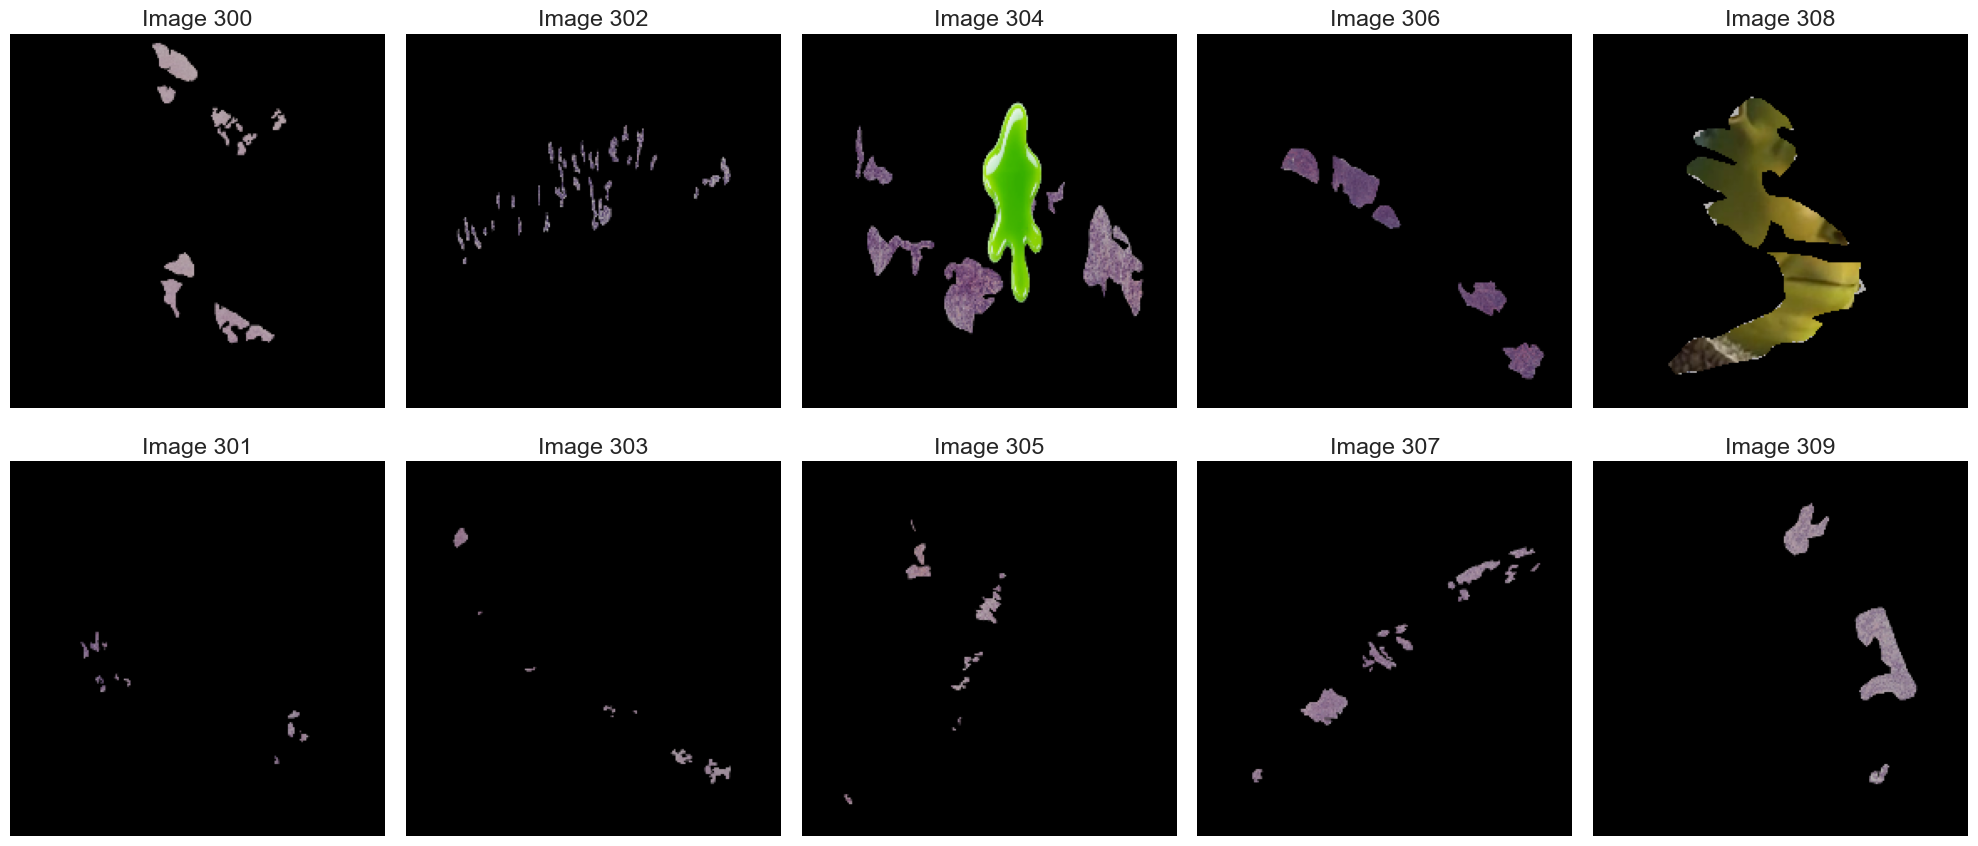

In [15]:
# Number of images to display
num_img = 10
start_img= 300
# Create subplots for displaying items
fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
for i in range(start_img, start_img+num_img):
    ax = axes[i%2, i%num_img//2]
    # Add the image index into the imageshow
    ax.set_title(f"Image {i}")
    ax.imshow(np.clip(train_images[i], 0, 1))  # Display clipped item images
    ax.axis('off')
plt.tight_layout()
plt.show()



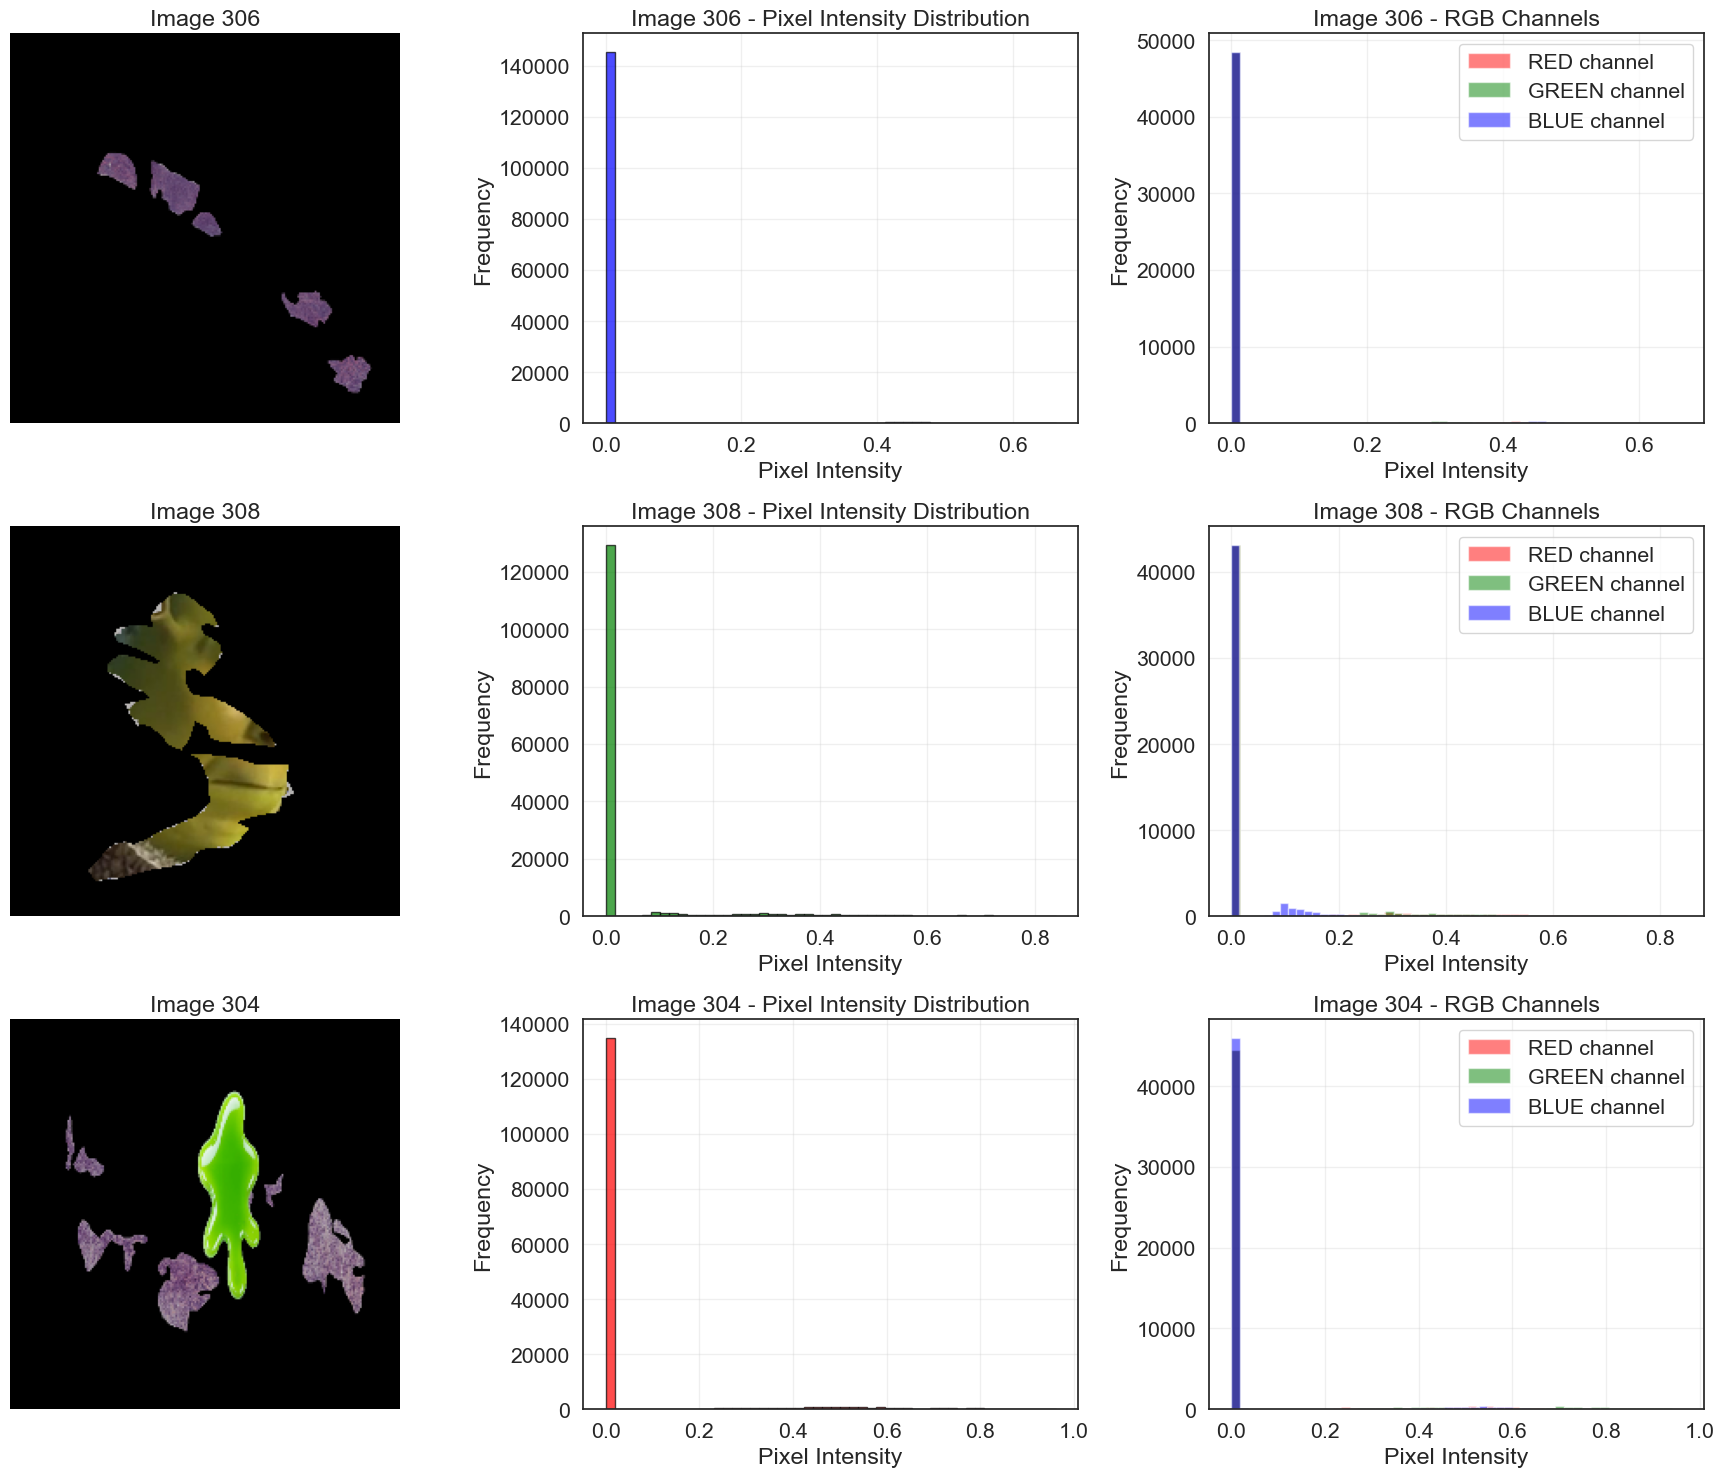

Image 306 Statistics:
  Mean intensity: 0.0128
  Std deviation: 0.0703
  Min: 0.0000, Max: 0.6627

Image 308 Statistics:
  Mean intensity: 0.0451
  Std deviation: 0.1300
  Min: 0.0000, Max: 0.8392

Image 304 Statistics:
  Mean intensity: 0.0520
  Std deviation: 0.1650
  Min: 0.0000, Max: 0.9608

Green Channel Statistics:
Image 304 - Green channel mean: 0.0635, std: 0.1924
Image 308 - Green channel mean: 0.0550, std: 0.1451

Red Channel Statistics:
Image 304 - Red channel mean: 0.0535, std: 0.1583
Image 308 - Red channel mean: 0.0587, std: 0.1562

Blue Channel Statistics:
Image 304 - Blue channel mean: 0.0391, std: 0.1390
Image 308 - Blue channel mean: 0.0215, std: 0.0666


In [16]:
# Compare pixel intensity distributions for images 306 and 308
img_306 = train_images[306]
img_308 = train_images[308]
img_304 = train_images[304]

fig, axes = plt.subplots(3, 3, figsize=(18, 15))

# Display Image 306
axes[0, 0].imshow(np.clip(img_306, 0, 1))
axes[0, 0].set_title("Image 306")
axes[0, 0].axis('off')

# Display Image 308
axes[1, 0].imshow(np.clip(img_308, 0, 1))
axes[1, 0].set_title("Image 308")
axes[1, 0].axis('off')

# Display Image 304
axes[2, 0].imshow(np.clip(img_304, 0, 1))
axes[2, 0].set_title("Image 304")
axes[2, 0].axis('off')

# Pixel intensity histogram for Image 306 (all channels combined)
axes[0, 1].hist(img_306.flatten(), bins=50, color='blue', alpha=0.7, edgecolor='black')
axes[0, 1].set_title("Image 306 - Pixel Intensity Distribution")
axes[0, 1].set_xlabel("Pixel Intensity")
axes[0, 1].set_ylabel("Frequency")
axes[0, 1].grid(True, alpha=0.3)

# Pixel intensity histogram for Image 308 (all channels combined)
axes[1, 1].hist(img_308.flatten(), bins=50, color='green', alpha=0.7, edgecolor='black')
axes[1, 1].set_title("Image 308 - Pixel Intensity Distribution")
axes[1, 1].set_xlabel("Pixel Intensity")
axes[1, 1].set_ylabel("Frequency")
axes[1, 1].grid(True, alpha=0.3)

# Pixel intensity histograms for Image 304
axes[2, 1].hist(img_304.flatten(), bins=50, color='red', alpha=0.7, edgecolor='black')
axes[2, 1].set_title("Image 304 - Pixel Intensity Distribution")
axes[2, 1].set_xlabel("Pixel Intensity")
axes[2, 1].set_ylabel("Frequency")
axes[2, 1].grid(True, alpha=0.3)

# RGB channel histograms for Image 306
for channel, color in enumerate(['red', 'green', 'blue']):
    axes[0, 2].hist(img_306[:, :, channel].flatten(), bins=50, 
                    color=color, alpha=0.5, label=f'{color.upper()} channel')
axes[0, 2].set_title("Image 306 - RGB Channels")
axes[0, 2].set_xlabel("Pixel Intensity")
axes[0, 2].set_ylabel("Frequency")
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# RGB channel histograms for Image 308
for channel, color in enumerate(['red', 'green', 'blue']):
    axes[1, 2].hist(img_308[:, :, channel].flatten(), bins=50, 
                    color=color, alpha=0.5, label=f'{color.upper()} channel')
axes[1, 2].set_title("Image 308 - RGB Channels")
axes[1, 2].set_xlabel("Pixel Intensity")
axes[1, 2].set_ylabel("Frequency")
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

# RGB channel histograms for Image 304
for channel, color in enumerate(['red', 'green', 'blue']):
    axes[2, 2].hist(img_304[:, :, channel].flatten(), bins=50, 
                    color=color, alpha=0.5, label=f'{color.upper()} channel')
axes[2, 2].set_title("Image 304 - RGB Channels")
axes[2, 2].set_xlabel("Pixel Intensity")
axes[2, 2].set_ylabel("Frequency")
axes[2, 2].legend()
axes[2, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print("Image 306 Statistics:")
print(f"  Mean intensity: {img_306.mean():.4f}")
print(f"  Std deviation: {img_306.std():.4f}")
print(f"  Min: {img_306.min():.4f}, Max: {img_306.max():.4f}")

print("\nImage 308 Statistics:")
print(f"  Mean intensity: {img_308.mean():.4f}")
print(f"  Std deviation: {img_308.std():.4f}")
print(f"  Min: {img_308.min():.4f}, Max: {img_308.max():.4f}")

print("\nImage 304 Statistics:")
print(f"  Mean intensity: {img_304.mean():.4f}")
print(f"  Std deviation: {img_304.std():.4f}")
print(f"  Min: {img_304.min():.4f}, Max: {img_304.max():.4f}")

# Print green channel statistics for images 304 and 308
print("\nGreen Channel Statistics:")
print(f"Image 304 - Green channel mean: {img_304[:, :, 1].mean():.4f}, std: {img_304[:, :, 1].std():.4f}")
print(f"Image 308 - Green channel mean: {img_308[:, :, 1].mean():.4f}, std: {img_308[:, :, 1].std():.4f}")

# Print red channel statistics for images 304 and 308
print("\nRed Channel Statistics:")
print(f"Image 304 - Red channel mean: {img_304[:, :, 0].mean():.4f}, std: {img_304[:, :, 0].std():.4f}")
print(f"Image 308 - Red channel mean: {img_308[:, :, 0].mean():.4f}, std: {img_308[:, :, 0].std():.4f}")

# Print blue channel statistics for images 304 and 308
print("\nBlue Channel Statistics:")
print(f"Image 304 - Blue channel mean: {img_304[:, :, 2].mean():.4f}, std: {img_304[:, :, 2].std():.4f}")
print(f"Image 308 - Blue channel mean: {img_308[:, :, 2].mean():.4f}, std: {img_308[:, :, 2].std():.4f}")


Analyzing green channel frequency for all images...


Analyzing images: 100%|██████████| 1412/1412 [00:00<00:00, 7177.32it/s]




Top 20 images with highest green intensity frequency (>0.5):
Index | High Green % | Dominant Green %
--------------------------------------------------
 1134 |       13.35% |            0.00%
  602 |       11.55% |            0.02%
  436 |       10.32% |            5.16%
  223 |        9.83% |            5.11%
  442 |        9.66% |            5.10%
  964 |        9.58% |            0.00%
 1266 |        9.11% |            0.01%
  687 |        7.73% |            5.11%
 1090 |        6.92% |            0.00%
  489 |        6.81% |            5.07%
  992 |        6.29% |            5.11%
  714 |        6.21% |            5.07%
  239 |        6.18% |            5.06%
 1039 |        6.14% |            5.09%
 1346 |        6.09% |            0.00%
  592 |        6.05% |            5.10%
  304 |        6.01% |            5.12%
  676 |        6.00% |            0.01%
 1054 |        5.94% |            0.00%
  893 |        5.84% |            5.08%


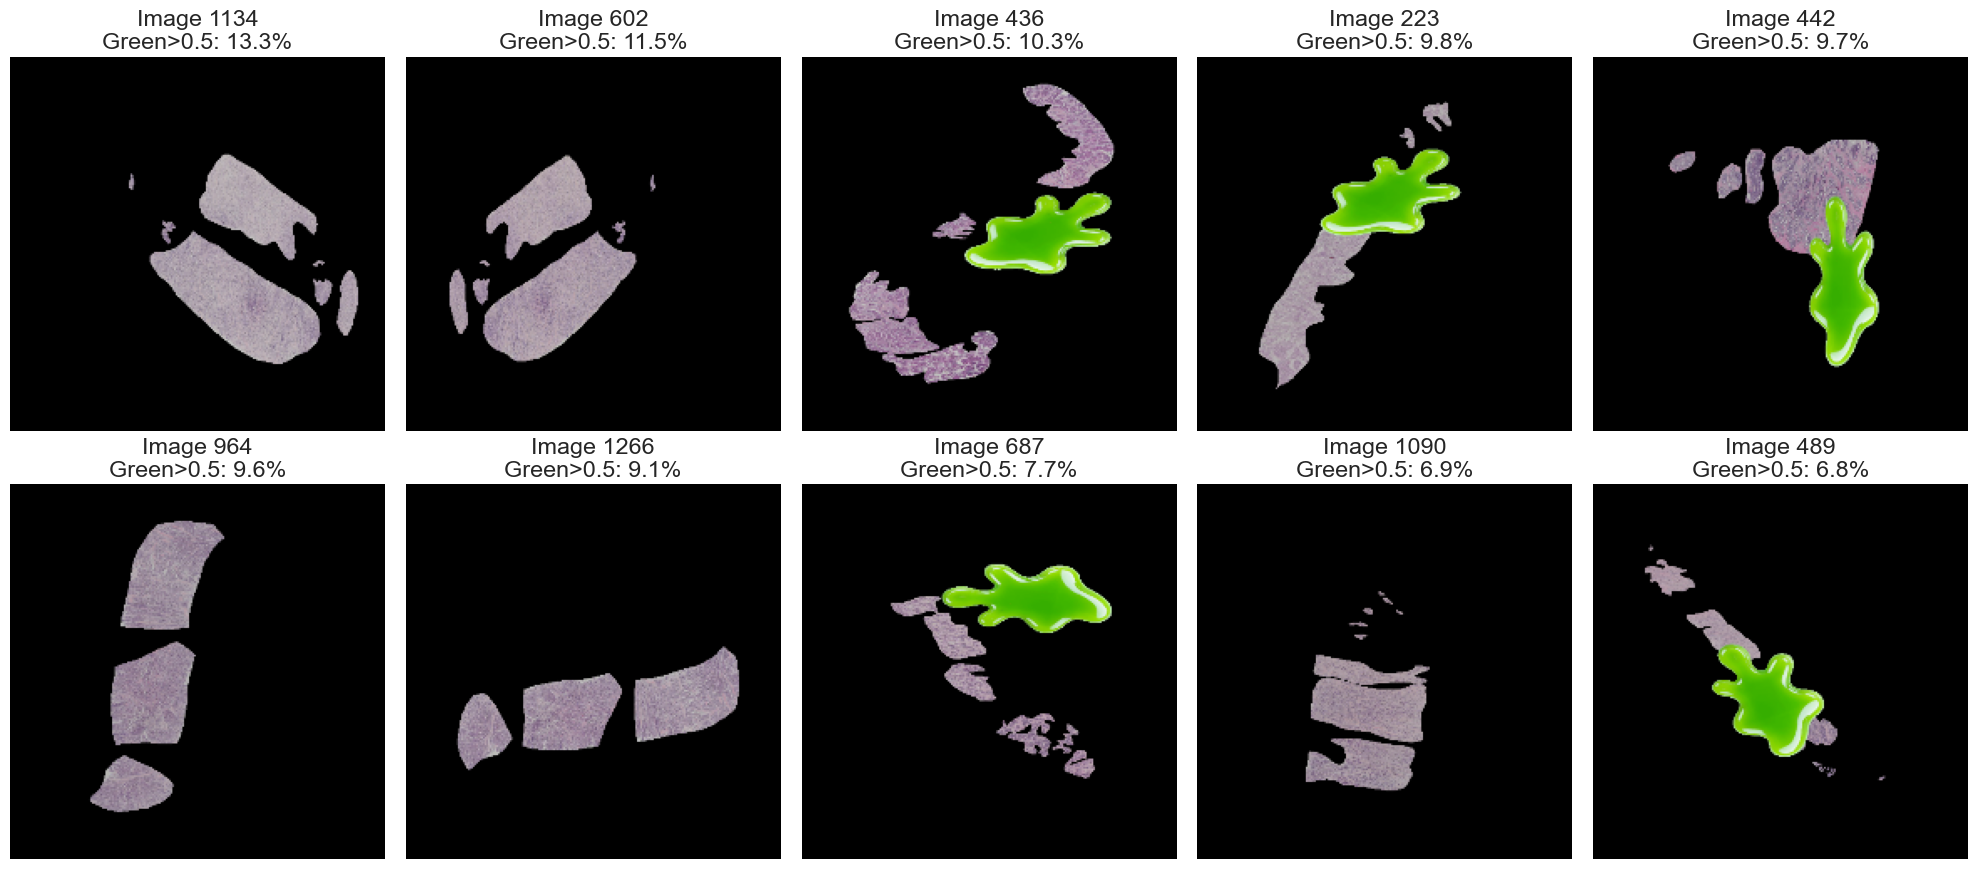


Selected 0 images with >20.0% high green intensity
Indices: []

Stored 0 images in 'selected_green_images' array
Shape: (0, 224, 224, 3)


In [17]:
# Identify images with high green channel intensity frequency
# Based on the histogram analysis, select images where green channel dominates

def analyze_green_frequency(image):
    """
    Analyze green channel frequency distribution.
    Returns the percentage of pixels where green channel has high intensity (>0.5)
    and where green is the dominant channel.
    """
    green_channel = image[:, :, 1]
    
    # Count pixels with high green intensity (>0.5)
    high_green_pixels = np.sum(green_channel > 0.5)
    
    # Count pixels where green is dominant (G > R and G > B)
    green_dominant = np.sum(
        (image[:, :, 1] > image[:, :, 0]) & 
        (image[:, :, 1] > image[:, :, 2])
    )
    
    total_pixels = image.shape[0] * image.shape[1]
    high_green_percentage = (high_green_pixels / total_pixels) * 100
    dominant_green_percentage = (green_dominant / total_pixels) * 100
    
    return high_green_percentage, dominant_green_percentage

# Analyze all images
print("Analyzing green channel frequency for all images...")
green_analysis = []
for idx, img in enumerate(tqdm(train_images, desc="Analyzing images")):
    high_green_pct, dominant_green_pct = analyze_green_frequency(img)
    green_analysis.append({
        'index': idx,
        'high_green_pct': high_green_pct,
        'dominant_green_pct': dominant_green_pct
    })

# Convert to DataFrame for easy sorting
df_green = pd.DataFrame(green_analysis)

# Sort by high green intensity percentage
df_sorted_high = df_green.sort_values('high_green_pct', ascending=False)

# Display top 20 images with highest green intensity frequency
print("\nTop 20 images with highest green intensity frequency (>0.5):")
print("Index | High Green % | Dominant Green %")
print("-" * 50)
for _, row in df_sorted_high.head(20).iterrows():
    print(f"{int(row['index']):5d} | {row['high_green_pct']:11.2f}% | {row['dominant_green_pct']:15.2f}%")

# Visualize top 10 images with highest green frequency
fig, axes = plt.subplots(2, 5, figsize=(20, 9))
axes = axes.flatten()
for i, (_, row) in enumerate(df_sorted_high.head(10).iterrows()):
    idx = int(row['index'])
    axes[i].imshow(np.clip(train_images[idx], 0, 1))
    axes[i].set_title(f"Image {idx}\nGreen>0.5: {row['high_green_pct']:.1f}%")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# Select images based on threshold
green_threshold = 20.0  # Select images with >20% high green intensity
selected_green_indices = df_green[df_green['high_green_pct'] > green_threshold]['index'].values.astype(int).tolist()

print(f"\nSelected {len(selected_green_indices)} images with >{green_threshold}% high green intensity")
print(f"Indices: {selected_green_indices[:50]}")  # Show first 50

# Store the selected images
selected_green_images = train_images[selected_green_indices]
print(f"\nStored {len(selected_green_images)} images in 'selected_green_images' array")
print(f"Shape: {selected_green_images.shape}")

### Green Area Removal Filter

In [18]:
def filter_bright_green_areas(image, lg_H=60-50, lg_S=10, lg_V=50, ug_H=60+50, ug_S=255, ug_V=255, dilate_iterations=2):
    """ 
    Filters out bright green areas from the input image with improved residual removal.
    
    Args:
        image: Input image in RGB format (0-1 range)
        lg_H, lg_S, lg_V: Lower bounds for HSV green detection
        ug_H, ug_S, ug_V: Upper bounds for HSV green detection
        dilate_iterations: Number of dilation iterations to expand mask (removes edge artifacts)
    """

    # Convert from RGB (0-1) to BGR (0-255) for OpenCV
    original_bgr = (image * 255).astype(np.uint8)[..., ::-1]

    # 1. Convert to HSV (Hue, Saturation, Value)
    hsv = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2HSV)

    # 2. Define the "Bright Green" Range
    lower_green = (lg_H, lg_S, lg_V)
    upper_green = (ug_H, ug_S, ug_V)

    # Create the initial mask
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # 3. Morphological operations to clean up the mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

    # OPEN: Remove small noise
    clean_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)

    # DILATE: Expand the mask to catch edge artifacts and residuals
    # This ensures we remove green pixels at the boundaries
    if dilate_iterations > 0:
        clean_mask = cv2.dilate(clean_mask, kernel, iterations=dilate_iterations)

    # 4. Additional step: Detect any remaining green-ish pixels
    # Create a more aggressive mask for subtle green tones
    lower_green_subtle = (max(0, lg_H - 10), max(0, lg_S - 10), 0)
    upper_green_subtle = (min(180, ug_H + 10), 255, 255)
    subtle_mask = cv2.inRange(hsv, lower_green_subtle, upper_green_subtle)
    
    # Only keep subtle green pixels that are near the main green area
    subtle_mask = cv2.morphologyEx(subtle_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    
    # Combine masks
    combined_mask = cv2.bitwise_or(clean_mask, subtle_mask)

    # 5. Invert mask to keep the useful parts
    mask_inv = cv2.bitwise_not(combined_mask)

    # 6. Apply the mask
    result_bgr = cv2.bitwise_and(original_bgr, original_bgr, mask=mask_inv)

    return result_bgr, combined_mask

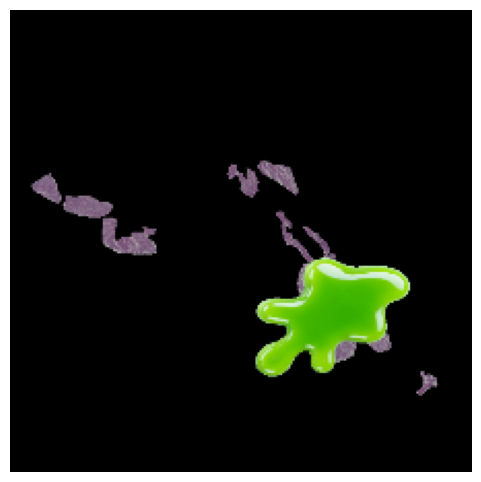

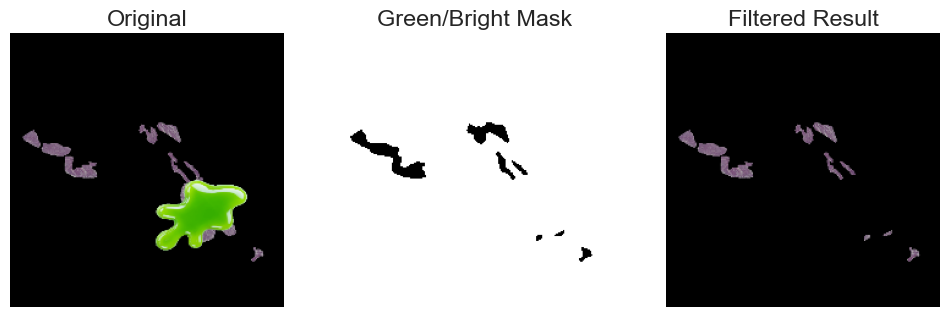

In [ ]:
# Display the pixels values of an image with green areas
image_index = 102
image = train_images[image_index]
plt.figure(figsize=(6, 6))
plt.imshow(np.clip(image, 0, 1))
plt.axis('off')
plt.show()

result_bgr, clean_mask = filter_bright_green_areas(image)

# --- Display Results ---
plt.figure(figsize=(12, 6))

# Original
plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(np.clip(image, 0, 1))
plt.axis('off')

# The Mask (Visualizing what we are removing)
plt.subplot(1, 3, 2)    
plt.title("Green/Bright Mask")
plt.imshow(clean_mask, cmap='gray')
plt.axis('off')

# Result
result_rgb = result_bgr[..., ::-1]
plt.subplot(1, 3, 3)
plt.title("Filtered Result")
plt.imshow(np.clip(result_rgb / 255.0, 0, 1))
plt.axis('off')

plt.show()

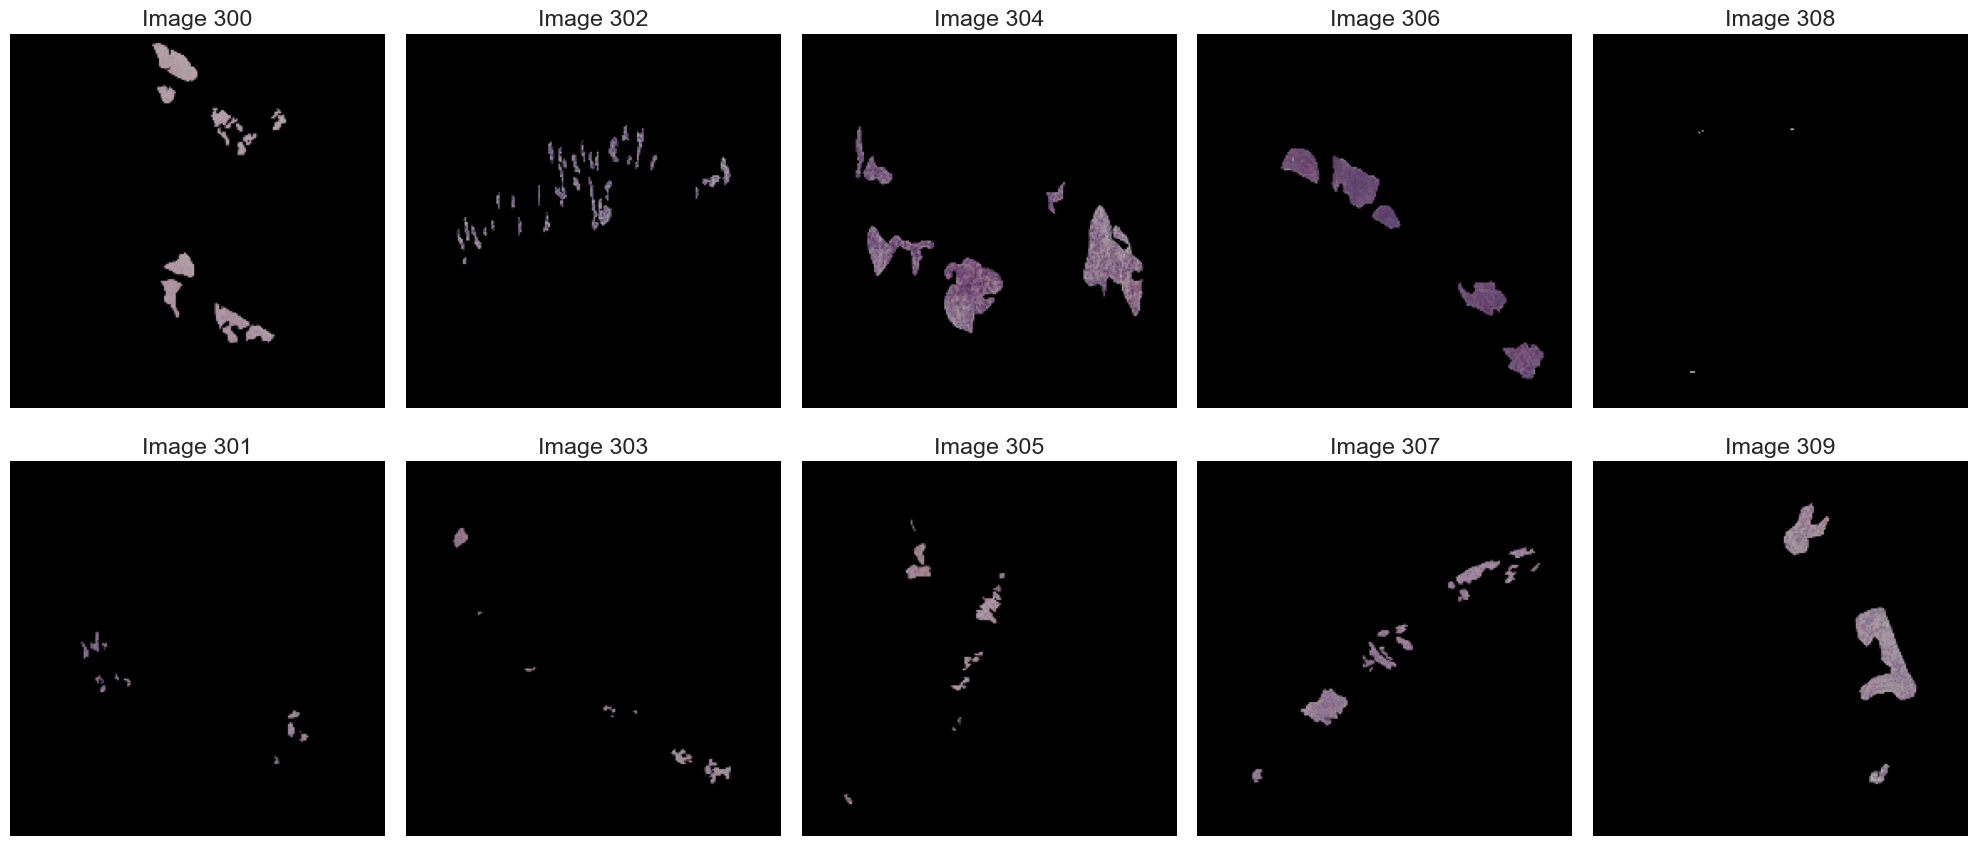

In [20]:
# Convert from BGR to RGB for displaying
result_rgb = result_bgr[..., ::-1]


# Apply the HSV filter for all the images into the training set and normalize them
for image in train_images:
    filtered_bgr, _ = filter_bright_green_areas(image)
    # Convert back to RGB and normalize to [0, 1]
    filtered_rgb = filtered_bgr[..., ::-1] / 255.0
    # Update the image in place
    image[:] = filtered_rgb

# Number of images to display
num_img = 10
start_img= 300
# Create again subplots for displaying the filtered items
fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
for i in range(start_img, start_img+num_img):
    ax = axes[i%2, i%num_img//2]
    ax.set_title(f"Image {i}")
    ax.imshow(np.clip(train_images[i], 0, 1))  # Display clipped item images
    ax.axis('off')
plt.tight_layout()
plt.show()


In [21]:
# Print RBG channel for 308 and 304 images
# Compare pixel intensity distributions for images 306 and 308
img_306 = train_images[306]
img_308 = train_images[308]

img_304 = train_images[304]

# Print green channel statistics for images 304 and 308
print("\nGreen Channel Statistics:")
print(f"Image 304 - Mean: {img_304[..., 1].mean()}, Std: {img_304[..., 1].std()}")
print(f"Image 308 - Mean: {img_308[..., 1].mean()}, Std: {img_308[..., 1].std()}")
print(f"Image 306 - Mean: {img_306[..., 1].mean()}, Std: {img_306[..., 1].std()}")

# Print blue channel statistics for images 304 and 308
print("\nBlue Channel Statistics:")
print(f"Image 304 - Mean: {img_304[..., 2].mean()}, Std: {img_304[..., 2].std()}")
print(f"Image 308 - Mean: {img_308[..., 2].mean()}, Std: {img_308[..., 2].std()}")
print(f"Image 306 - Mean: {img_306[..., 2].mean()}, Std: {img_306[..., 2].std()}")  

# Print red channel statistics for images 304 and 308
print("\nRed Channel Statistics:")
print(f"Image 304 - Mean: {img_304[..., 0].mean()}, Std: {img_304[..., 0].std()}")
print(f"Image 308 - Mean: {img_308[..., 0].mean()}, Std: {img_308[..., 0].std()}")

# Overall statistics
print("\nOverall Image Statistics After Filtering:")
print(f"Image 304 - Mean: {img_304.mean()}, Std: {img_304.std()}")
print(f"Image 308 - Mean: {img_308.mean()}, Std: {img_308.std()}")


Green Channel Statistics:
Image 304 - Mean: 0.024370374158024788, Std: 0.09883752465248108
Image 308 - Mean: 9.832058276515454e-05, Std: 0.00832502543926239
Image 306 - Mean: 0.009926704689860344, Std: 0.05407431349158287

Blue Channel Statistics:
Image 304 - Mean: 0.03088313713669777, Std: 0.12319359183311462
Image 308 - Mean: 0.00010074342571897432, Std: 0.008530670776963234
Image 306 - Mean: 0.014735582284629345, Std: 0.07977867126464844

Red Channel Statistics:
Image 304 - Mean: 0.030705874785780907, Std: 0.12297101318836212
Image 308 - Mean: 0.00010082157677970827, Std: 0.008537223562598228

Overall Image Statistics After Filtering:
Image 304 - Mean: 0.028653131797909737, Std: 0.11560697108507156
Image 308 - Mean: 9.996185690397397e-05, Std: 0.008464880287647247


In [22]:
# Remove images that have a overall mean lower or equal then 0.001
MEAN_LIMIT = 0.0001
tot_eliminated_imgs = []
kept_images = []
indx_eliminated = []

print(f"Total images before filtering: {len(train_images)}")

for idx in range(len(train_images)):
    if train_images[idx].mean() <= MEAN_LIMIT:
        tot_eliminated_imgs.append(train_images[idx])
        indx_eliminated.append(idx)
    else:
        kept_images.append(train_images[idx])

# Convert to numpy arrays
tot_eliminated_imgs = np.array(tot_eliminated_imgs)
train_images = np.array(kept_images)
check_correctly_removed = False                    # set it to true if you want to double check if the images were eliminated correctly

print(f"Eliminated {len(tot_eliminated_imgs)} images with mean <= {MEAN_LIMIT}")
print(f"Remaining images: {len(train_images)}")

# Print the eliminated images indices
print(f"Indices of eliminated images: {indx_eliminated}")

Total images before filtering: 1412
Eliminated 153 images with mean <= 0.0001
Remaining images: 1259
Indices of eliminated images: [33, 104, 112, 130, 135, 140, 147, 173, 189, 193, 203, 213, 218, 228, 237, 249, 250, 264, 269, 271, 290, 291, 308, 322, 328, 336, 342, 348, 365, 368, 370, 377, 379, 386, 394, 404, 406, 413, 418, 422, 426, 430, 438, 446, 447, 454, 456, 469, 478, 481, 495, 496, 505, 509, 514, 516, 527, 529, 536, 555, 574, 586, 589, 594, 606, 629, 631, 648, 653, 655, 665, 673, 681, 703, 731, 733, 735, 748, 753, 755, 758, 767, 771, 800, 813, 819, 825, 826, 832, 846, 868, 903, 917, 919, 930, 936, 937, 958, 960, 991, 999, 1005, 1006, 1011, 1015, 1017, 1035, 1037, 1046, 1062, 1114, 1124, 1125, 1133, 1139, 1150, 1156, 1177, 1184, 1186, 1192, 1206, 1212, 1217, 1220, 1229, 1236, 1241, 1245, 1254, 1258, 1261, 1263, 1274, 1277, 1280, 1281, 1298, 1317, 1335, 1340, 1341, 1344, 1360, 1361, 1367, 1369, 1375, 1376, 1377, 1381, 1385, 1389]
Eliminated 153 images with mean <= 0.0001
Remaining 

Not sherek removed images (wrong mask, or shifted):
(33, 135, 140, 277, 282, 369, 371, 377, 390, 496, 901, 917, 967, 1068, 1131, 1139, 1254, 1275, 1341, 1344)

In [23]:
# Remove the mask corresponding to the removed training images
filenames = os.listdir(MASKED_IMAGE_PATH)

for idx in indx_eliminated:
    img_name_jpg = f"img_{idx:04d}.jpg"
    img_name_png = f"img_{idx:04d}.png"
    if img_name_jpg in filenames:
        os.remove(os.path.join(MASKED_IMAGE_PATH, img_name_jpg))
    elif img_name_png in filenames:
        os.remove(os.path.join(MASKED_IMAGE_PATH, img_name_png))
    else:
        print(f"No mask file found for image index {idx}")

# Print the number of remaining mask files
remaining_files = os.listdir(MASKED_IMAGE_PATH)
print(f"Number of remaining mask files: {len(remaining_files)}")

Number of remaining mask files: 1259


In [24]:
# Plot up to 20 eliminated images
if check_correctly_removed:
    num_to_plot = min(20, len(tot_eliminated_imgs))

    if num_to_plot > 0:
        cols = 5
        rows = (num_to_plot + cols - 1) // cols  # Calculate rows needed
        
        fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows))
        axes = axes.flatten() if num_to_plot > 1 else [axes]
        
        for i in range(num_to_plot):
            axes[i].imshow(np.clip(tot_eliminated_imgs[i], 0, 1))
            axes[i].set_title(f"Eliminated {i}\nMean: {tot_eliminated_imgs[i].mean():.4f}")
            axes[i].axis('off')
        
        # Hide unused subplots
        for i in range(num_to_plot, len(axes)):
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
    else:
        print("No images were eliminated.")

### **Patches creation**

In [27]:
# Create a folder copy of the original training images with just the kept images
filtered_output_dir = source_dir.parent / "train_data_filtered"
filtered_output_dir.mkdir(parents=True, exist_ok=True)

# Calculate which indices to keep (all indices except the eliminated ones)
all_indices = set(range(len(kept_images) + len(indx_eliminated)))
kept_indices = sorted(all_indices - set(indx_eliminated))

print(f"Total original images: {len(all_indices)}")
print(f"Eliminated images: {len(indx_eliminated)}")
print(f"Kept images: {len(kept_indices)}")

copied_count = 0

for idx in kept_indices:
    
    img_name_png = f"img_{idx:04d}.png"
    mask_name_png = f"mask_{idx:04d}.png"

    src_path_png = source_dir / img_name_png
    src_mask_path_png = source_dir / mask_name_png
    
    if src_path_png.exists():
        dest_img_path = filtered_output_dir / img_name_png
        shutil.copy(src_path_png, dest_img_path)
        copied_count += 1

    elif src_mask_path_png.exists():
        dest_mask_path = filtered_output_dir / mask_name_png
        shutil.copy(src_path_png, dest_mask_path)
        copied_count += 1

    else:
        print(f"Warning: No original file found for image index {idx}")

print(f"\nCopied {copied_count} images to {filtered_output_dir}")

Total original images: 1412
Eliminated images: 153
Kept images: 1259

Copied 1259 images to C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2_prev\train_data_filtered

Copied 1259 images to C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2_prev\train_data_filtered


In [ ]:
def extract_mask_patches(image, mask, patch_size=224):
    patches = []
    
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        crop = image[y:y+h, x:x+w]

        # Resize to model input size
        crop = cv2.resize(crop, (patch_size, patch_size))
        patches.append(crop)

    return patches

In [ ]:
# Extract mask patches from images and masks
all_patches = []
patch_labels = []

# Get all image files from the training data folder
image_files = sorted([f for f in Path(SOURCE_FOLDER).iterdir() if f.name.startswith('img_')])

print(f"Processing {len(image_files)} images to extract masked patches...")

for img_file in tqdm(image_files, desc="Extracting patches"):
    # Construct corresponding mask filename
    mask_name = img_file.name.replace('img_', 'mask_', 1)
    mask_path = Path(SOURCE_FOLDER) / mask_name
    
    # Fallback to .png extension if needed
    if not mask_path.exists():
        mask_stem = img_file.stem.replace('img_', 'mask_', 1)
        mask_path = Path(SOURCE_FOLDER) / (mask_stem + ".png")
    
    if not mask_path.exists():
        tqdm.write(f"Warning: Mask not found for {img_file.name}")
        continue
    
    # Load image and mask
    img = cv2.imread(str(img_file))
    mask = cv2.imread(str(mask_path), 0)
    
    if img is None or mask is None:
        tqdm.write(f"Warning: Could not load {img_file.name} or its mask")
        continue
    
    # Binarize mask
    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    
    # Extract patches using the function
    patches = extract_mask_patches(img, binary_mask, patch_size=224)
    
    if patches:
        all_patches.extend(patches)
        # Store the image ID for later reference if needed
        img_id = img_file.stem.replace('img_', '')
        patch_labels.extend([img_id] * len(patches))

print(f"\nExtracted {len(all_patches)} patches from {len(image_files)} images")
print(f"Average patches per image: {len(all_patches) / len(image_files):.2f}")

# Convert to numpy array for further processing
if all_patches:
    extracted_patches = np.array(all_patches)
    print(f"Patches array shape: {extracted_patches.shape}")
else:
    print("Warning: No patches were extracted!")

In [ ]:
# Plot some example patches
num_examples = min(5, len(all_patches))
if num_examples > 0:
    plt.figure(figsize=(15, 5))
    for i in range(num_examples):
        plt.subplot(1, num_examples, i + 1)
        plt.imshow(cv2.cvtColor(all_patches[i], cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.suptitle("Example Extracted Masked Patches", fontsize=16)
    plt.show()

### **Splitting the dataset**

In [55]:
from sklearn.preprocessing import LabelEncoder

X_aligned = []
y_aligned = []

# Create a csv file with the remaining images labels
original_labels_df = pd.read_csv(CSV_PATH) 

# Create a new csv file called train_labels_rm.csv
new_csv_path = os.path.join(datasets_path, "train_labels_rm.csv")

with open(new_csv_path, 'w') as f:
    f.write("sample_index,label\n")
    for idx in range(len(original_labels_df)):
        if idx not in indx_eliminated:
            f.write(f"{original_labels_df.iloc[idx, 0]},{original_labels_df.iloc[idx, 1]}\n")

# Load the removed labels CSV
labels_df = pd.read_csv(new_csv_path)

# Create a dictionary mapping filename -> label for fast lookup
labels_map = dict(zip(labels_df.iloc[:, 0], labels_df.iloc[:, 1])) 

# Reload filenames from the masked image folder after elimination
filenames = os.listdir(MASKED_IMAGE_PATH)

# Check alignment
print(f"Number of filenames: {len(filenames)}")
print(f"Number of train_images: {len(train_images)}")

if len(filenames) != len(train_images):
    raise ValueError(f"Mismatch! Loaded images ({len(train_images)}) != Files found ({len(filenames)}).")

for i, filename in enumerate(filenames):
    if filename in labels_map:
        # If the file exists in our CSV, keep the image and the label
        X_aligned.append(train_images[i])
        y_aligned.append(labels_map[filename])
    else:
        # If image is in folder but NOT in CSV, we must discard the image
        print(f"Skipping {filename}: Image found but no label in CSV.")

# Convert to numpy arrays
X = np.array(X_aligned)
y = np.array(y_aligned)

print(f"Images aligned: {X.shape}")
print(f"Labels aligned: {y.shape}")

# 4. Encode labels (String -> Integer)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Print class mapping
print("Classes:", label_encoder.classes_)

# 5. Train-Test Split (Stratified)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, 
    test_size=0.2, 
    random_state=SEED, 
    stratify=y_encoded
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=SEED,
    stratify=y_temp
)

print(f"Training data shape: {X_train.shape}, Labels: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Labels: {y_val.shape}")
print(f"Test data shape: {X_test.shape}, Labels: {y_test.shape}")

Number of filenames: 1257
Number of train_images: 1257
Images aligned: (1257, 512, 512, 3)
Labels aligned: (1257,)
Classes: ['HER2(+)' 'Luminal A' 'Luminal B' 'Triple negative']
Images aligned: (1257, 512, 512, 3)
Labels aligned: (1257,)
Classes: ['HER2(+)' 'Luminal A' 'Luminal B' 'Triple negative']
Training data shape: (1005, 512, 512, 3), Labels: (1005,)
Validation data shape: (126, 512, 512, 3), Labels: (126,)
Test data shape: (126, 512, 512, 3), Labels: (126,)
Training data shape: (1005, 512, 512, 3), Labels: (1005,)
Validation data shape: (126, 512, 512, 3), Labels: (126,)
Test data shape: (126, 512, 512, 3), Labels: (126,)


## 4. **Training**

In [56]:
# Define the input shape based on the training data
input_shape = (X_train.shape[3], X_train.shape[1], X_train.shape[2])

# Define the number of classes
num_classes = len(np.unique(y_train))

print("Input Shape:", input_shape)
print("Number of Classes:", num_classes)

Input Shape: (3, 512, 512)
Number of Classes: 4


In [57]:
# Convert numpy arrays to PyTorch datasets (without augmentation for now)
train_ds = TensorDataset(
    torch.from_numpy(X_train).permute(0, 3, 1, 2),
    torch.from_numpy(y_train).squeeze().long()
)
val_ds = TensorDataset(
    torch.from_numpy(X_val).permute(0, 3, 1, 2),
    torch.from_numpy(y_val).squeeze().long()
)
test_ds = TensorDataset(
    torch.from_numpy(X_test).permute(0, 3, 1, 2),
    torch.from_numpy(y_test).squeeze().long()
)

In [58]:
# Define the batch size
BATCH_SIZE = 32

In [59]:
# ImageNet normalization statistics
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

class TissueDataset(torch.utils.data.Dataset):
    """Custom PyTorch Dataset augmentation and normalization."""

    def __init__(self, data, labels, augmentation=None, normalize_imagenet=False):
        """
        Args:
            data: numpy array of images (N, H, W, C) in range [0, 1]
            labels: numpy array of labels
            augmentation: transforms for data augmentation
            normalize_imagenet: whether to apply ImageNet normalization
        """
        # Convert from (N, H, W, C) to (N, C, H, W) for PyTorch
        self.data = torch.from_numpy(data).permute(0, 3, 1, 2)
        self.labels = torch.from_numpy(labels).long()
        self.augmentation = augmentation
        self.normalize_imagenet = normalize_imagenet

        # ImageNet normalization transform
        if normalize_imagenet:
            self.normalize = transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
        else:
            self.normalize = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx].clone()  # Clone to avoid modifying original (already in C, H, W format)
        label = self.labels[idx]

        # Apply augmentation if provided (on images in [0, 1] range)
        if self.augmentation:
            image = self.augmentation(image)

        # Apply ImageNet normalization if requested
        if self.normalize:
            image = self.normalize(image)

        return image, label

In [60]:
def make_loader(ds, batch_size, shuffle, drop_last):
    """
    Create a PyTorch DataLoader with optimized settings.

    Args:
        ds (Dataset): PyTorch Dataset object
        batch_size (int): Number of samples per batch
        shuffle (bool): Whether to shuffle data at each epoch
        drop_last (bool): Whether to drop last incomplete batch

    Returns:
        DataLoader: Configured DataLoader instance
    """
    # Use 0 workers on Windows to avoid multiprocessing issues
    # Single-threaded loading is more stable on Windows
    num_workers = 0

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
    )

###  🧮 **Network Parameters**

In [61]:
# Training parameters
LEARNING_RATE = 3e-4
EPOCHS = 200
PATIENCE = 100

# Regularization
DROPOUT_RATE = 0.3
L2_REGULARIZATION = 1e-3

# Set up loss function
criterion = nn.CrossEntropyLoss()

# Print the defined parameters
print("Epochs:", EPOCHS)
print("Batch Size:", BATCH_SIZE)
print("Learning Rate:", LEARNING_RATE)
print("Dropout Rate:", DROPOUT_RATE)
print("Patience:", PATIENCE)

Epochs: 200
Batch Size: 32
Learning Rate: 0.0003
Dropout Rate: 0.3
Patience: 100


###  🧠 **Training Functions**

In [62]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

In [63]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        use_amp = device.type == 'cuda' and scaler is not None
        with torch.amp.autocast(device_type=device.type, enabled=use_amp):
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm

        # Backward pass with gradient scaling (only if scaler is provided)
        if use_amp:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    all_targets_concat = np.concatenate(all_targets)
    all_predictions_concat = np.concatenate(all_predictions)
    
    epoch_f1 = f1_score(all_targets_concat, all_predictions_concat, average='weighted')
    epoch_precision = precision_score(all_targets_concat, all_predictions_concat, average='weighted', zero_division=0)
    epoch_recall = recall_score(all_targets_concat, all_predictions_concat, average='weighted', zero_division=0)

    return epoch_loss, epoch_f1, epoch_precision, epoch_recall

In [64]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    all_targets_concat = np.concatenate(all_targets)
    all_predictions_concat = np.concatenate(all_predictions)
    
    epoch_f1 = f1_score(all_targets_concat, all_predictions_concat, average='weighted')
    epoch_precision = precision_score(all_targets_concat, all_predictions_concat, average='weighted', zero_division=0)
    epoch_recall = recall_score(all_targets_concat, all_predictions_concat, average='weighted', zero_division=0)

    return epoch_loss, epoch_f1, epoch_precision, epoch_recall

In [65]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name="", scheduler=None):
    """
    Train the neural network model on the training data and validate on the validation data.

# NOTE: Graphviz visualization commented out - requires Graphviz installation



# model_graph.visual_graph# model_graph = draw_graph(scratch_model, input_size=(BATCH_SIZE,)+input_shape, expand_nested=True, depth=6)# After installing Graphviz, restart kernel and uncomment these lines:        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_f1': [], 'val_f1': [],
        'train_precision': [], 'val_precision': [],
        'train_recall': [], 'val_recall': []
    }

    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    for epoch in range(1, epochs + 1):
        train_loss, train_f1, train_precision, train_recall = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device
        )

        val_loss, val_f1, val_precision, val_recall = validate_one_epoch(
            model, val_loader, criterion, device
        )

        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_acc'].append(train_f1)  # For backward compatibility
        training_history['val_acc'].append(val_f1)  # For backward compatibility
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)
        training_history['train_precision'].append(train_precision)
        training_history['val_precision'].append(val_precision)
        training_history['train_recall'].append(train_recall)
        training_history['val_recall'].append(val_recall)

        if writer is not None:
            writer.add_scalar('Loss/Training', train_loss, epoch)
            writer.add_scalar('Loss/Validation', val_loss, epoch)
            writer.add_scalar('F1/Training', train_f1, epoch)
            writer.add_scalar('F1/Validation', val_f1, epoch)
            writer.add_scalar('Precision/Training', train_precision, epoch)
            writer.add_scalar('Precision/Validation', val_precision, epoch)
            writer.add_scalar('Recall/Training', train_recall, epoch)
            writer.add_scalar('Recall/Validation', val_recall, epoch)

        if verbose and epoch % verbose == 0:
            print(f"Epoch {epoch:3d}/{epochs} | "
                  f"Train: Loss={train_loss:.4f}, F1={train_f1:.4f}, Prec={train_precision:.4f}, Rec={train_recall:.4f} | "
                  f"Val: Loss={val_loss:.4f}, F1={val_f1:.4f}, Prec={val_precision:.4f}, Rec={val_recall:.4f}")

        # Learning rate scheduling
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_f1)  # Step based on validation F1
            else:
                scheduler.step()  # For other schedulers

        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                model_path = f"models/{experiment_name}_best_model.pt"
                torch.save(model.state_dict(), model_path)
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break
                    
    if restore_best_weights and patience > 0:
        model_path = f"models/{experiment_name}_best_model.pt"
        model.load_state_dict(torch.load(model_path))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")
    return model, training_history

 ###  🛠️ **Train from Scratch**

In [66]:
# Improved ResNet architecture with better classifier head
class ResNetFromScratch(nn.Module):
    """ResNet trained from scratch with improved classifier head."""

    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()

        # Load architecture with NO pretrained weights
        self.backbone = torchvision.models.resnet50(weights=None)

        # Remove the original fc layer
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()  # Remove original classifier

        # Build a more sophisticated classifier head
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

In [67]:
# Initialize model
scratch_model = ResNetFromScratch(num_classes, DROPOUT_RATE).to(device)

# Visualize structure
summary(scratch_model, input_size=input_shape)
# model_graph = draw_graph(scratch_model, input_size=(BATCH_SIZE,)+input_shape, expand_nested=True, depth=6)
# model_graph.visual_graph

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,408
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]           4,096
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,864
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11        [-1, 256, 128, 128]          16,384
      BatchNorm2d-12        [-1, 256, 128, 128]             512
           Conv2d-13        [-1, 256, 128, 128]          16,384
      BatchNorm2d-14        [-1, 256, 1

In [68]:
# Print total parameters
total_params = sum(p.numel() for p in scratch_model.parameters())
trainable_params = sum(p.numel() for p in scratch_model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Total parameters: 24,691,012
Trainable parameters: 24,691,012


In [69]:
# Define augmentation for training with enhanced transformations
train_augmentation = transforms.Compose([
    # Geometric transformations
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),  # Small rotations to handle orientation variations
    transforms.RandomAffine(
        degrees=0, 
        translate=(0.1, 0.1),  # Reduced from 0.2 for more conservative shifts
        scale=(0.9, 1.1),  # Add scale variation
        shear=10  # Add shear transformation
    ),
    
    # Color/appearance transformations
    transforms.ColorJitter(
        brightness=0.2,  # Adjust brightness
        contrast=0.2,    # Adjust contrast
        saturation=0.2,  # Adjust saturation
        hue=0.1          # Slight hue variation
    ),
    transforms.RandomGrayscale(p=0.1),  # Occasionally convert to grayscale to improve robustness
    
    # Occlusion simulation
    transforms.RandomErasing(
        p=0.3,  # Reduced probability for more balanced augmentation
        scale=(0.02, 0.15),  # Reduced max scale
        ratio=(0.3, 3.3)  # Aspect ratio range
    ),
    
    # Optional: Add Gaussian blur for noise robustness
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
])

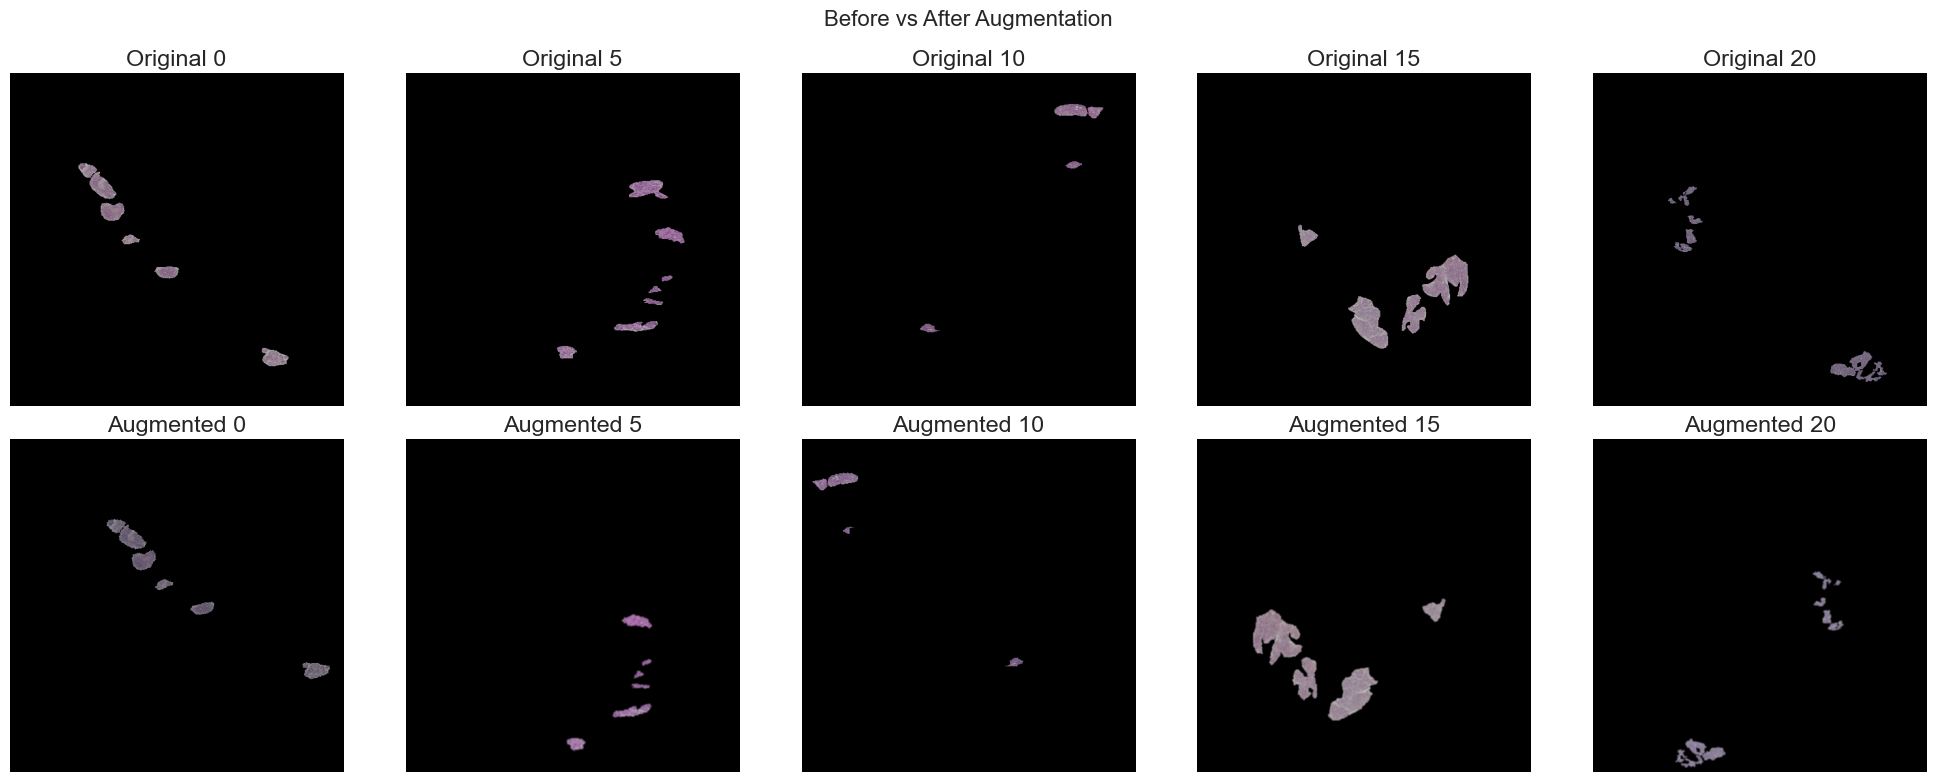


Multiple augmentations of the same image (showing randomness):


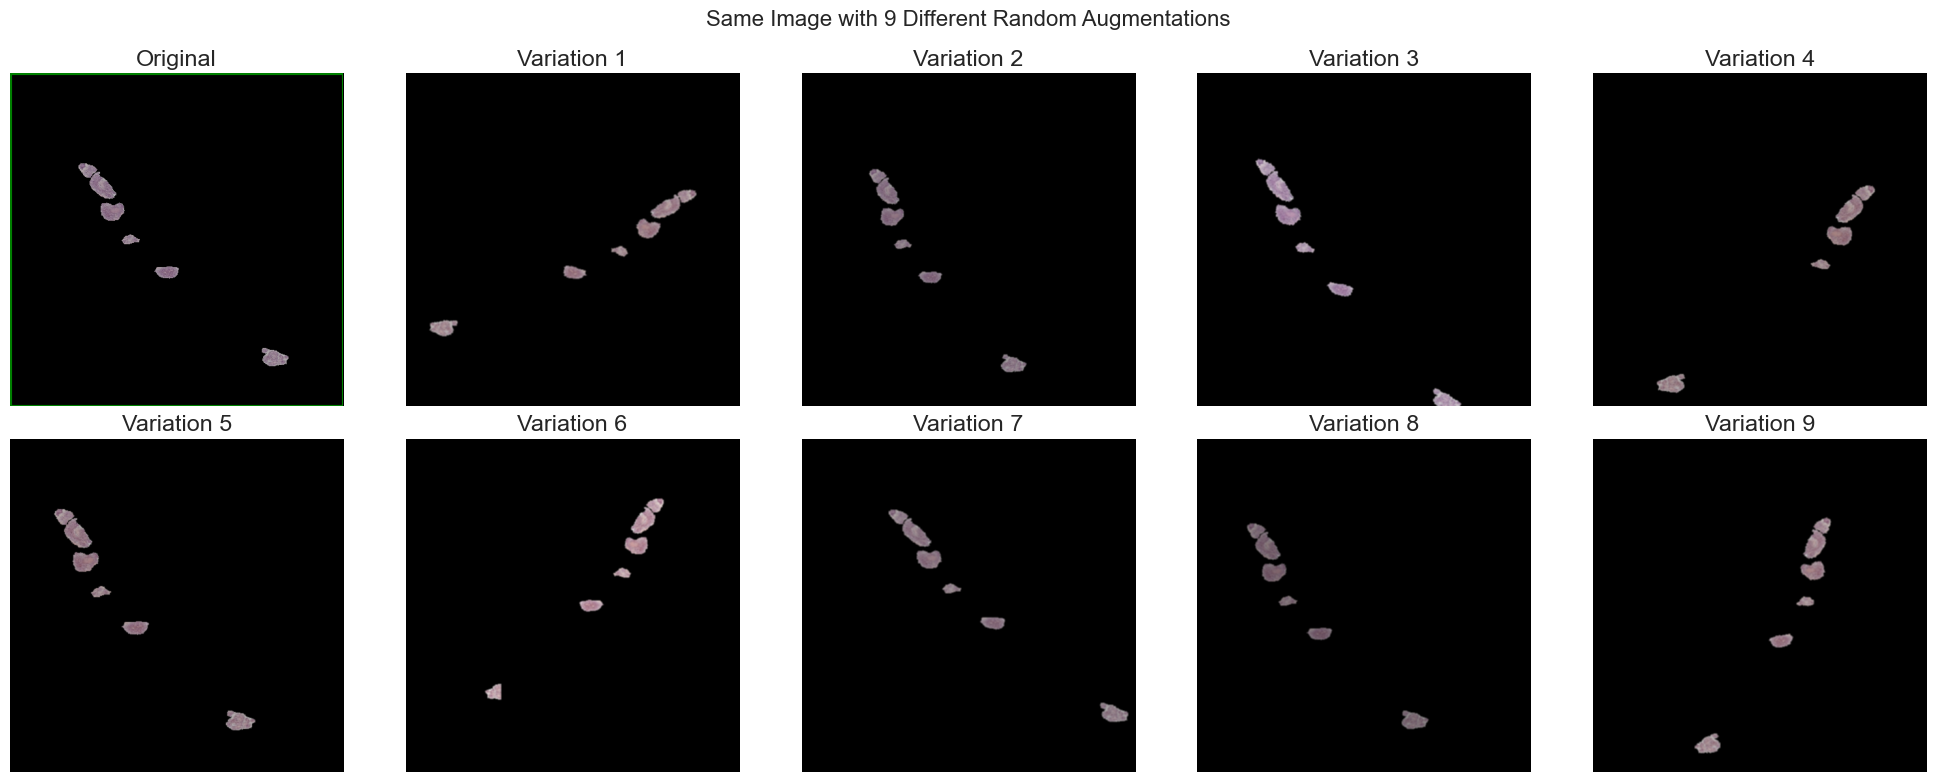

In [70]:
# Visualize augmentation effects by comparing original vs augmented images side-by-side
# This shows how RandomHorizontalFlip, RandomAffine, and RandomErasing transform the images

# Select a few sample images
num_samples = 5
sample_indices = [0, 5, 10, 15, 20]

# Create a grid: original on top row, augmented on bottom row
fig, axes = plt.subplots(2, num_samples, figsize=(20, 8))

for col, idx in enumerate(sample_indices):
    # Original image
    original_img = X_train[idx]
    axes[0, col].imshow(np.clip(original_img, 0, 1))
    axes[0, col].set_title(f"Original {idx}")
    axes[0, col].axis('off')
    
    # Apply augmentation
    sample_tensor = torch.from_numpy(original_img).permute(2, 0, 1)  # Convert to C,H,W
    augmented_tensor = train_augmentation(sample_tensor)
    augmented_img = augmented_tensor.permute(1, 2, 0).numpy()  # Back to H,W,C
    
    axes[1, col].imshow(np.clip(augmented_img, 0, 1))
    axes[1, col].set_title(f"Augmented {idx}")
    axes[1, col].axis('off')

plt.suptitle("Before vs After Augmentation", fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

# Show multiple augmented versions of the same image
print("\nMultiple augmentations of the same image (showing randomness):")
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

sample_idx = 0
sample_img = X_train[sample_idx]

# Show original once
axes[0, 0].imshow(np.clip(sample_img, 0, 1))
axes[0, 0].set_title("Original")
axes[0, 0].axis('off')
axes[0, 0].add_patch(plt.Rectangle((0, 0), sample_img.shape[1], sample_img.shape[0], 
                                    fill=False, edgecolor='green', linewidth=3))

# Show 9 different augmented versions
for i in range(9):
    row = (i + 1) // 5
    col = (i + 1) % 5
    
    sample_tensor = torch.from_numpy(sample_img).permute(2, 0, 1)
    augmented_tensor = train_augmentation(sample_tensor)
    augmented_img = augmented_tensor.permute(1, 2, 0).numpy()
    
    axes[row, col].imshow(np.clip(augmented_img, 0, 1))
    axes[row, col].set_title(f"Variation {i+1}")
    axes[row, col].axis('off')

plt.suptitle(f"Same Image with 9 Different Random Augmentations", fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

In [71]:
# Create datasets and dataloaders with augmentation for training set
train_scratch_ds = TissueDataset(X_train, y_train, augmentation=train_augmentation, normalize_imagenet=False)
val_scratch_ds = TissueDataset(X_val, y_val, augmentation=None, normalize_imagenet=False)

train_scratch_loader = make_loader(train_scratch_ds, BATCH_SIZE, shuffle=True, drop_last=False)
val_scratch_loader = make_loader(val_scratch_ds, BATCH_SIZE, shuffle=False, drop_last=False)

# Check a sample batch
sample_batch, sample_labels = next(iter(train_scratch_loader))

# Validate data before training
print("\nData Validation:")
print(f"Train samples: {len(train_scratch_ds)}")
print(f"Val samples: {len(val_scratch_ds)}")
print(f"Batch shape: {sample_batch.shape}")
print(f"Batch value range: [{sample_batch.min():.3f}, {sample_batch.max():.3f}]")
print(f"Labels in batch: {sample_labels[:10].tolist()}")
print(f"Number of classes: {num_classes}")
print(f"Class distribution in training: {np.bincount(y_train)}")


Data Validation:
Train samples: 1005
Val samples: 126
Batch shape: torch.Size([32, 3, 512, 512])
Batch value range: [0.000, 1.000]
Labels in batch: [0, 2, 1, 0, 1, 1, 0, 1, 0, 2]
Number of classes: 4
Class distribution in training: [258 271 354 122]


### 🔍 **Preprocessing Verification** 

Run this cell to verify your images are correctly preprocessed:

In [72]:
# Setup Training
experiment_name = "from_scratch"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)

optimizer = torch.optim.Adam(scratch_model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# Add learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5
)

scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

print(f"Experiment: {experiment_name}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Weight decay: 1e-4")
print(f"LR scheduler: ReduceLROnPlateau (patience=5)")
print(f"Early stopping patience: {PATIENCE}")

Experiment: from_scratch
Learning rate: 0.0003
Weight decay: 1e-4
LR scheduler: ReduceLROnPlateau (patience=5)
Early stopping patience: 100


In [74]:
# Train improved model with all fixes
scratch_model, scratch_history = fit(
    model=scratch_model,
    train_loader=train_scratch_loader,
    val_loader=val_scratch_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    l2_lambda=L2_REGULARIZATION,
    writer=writer,
    scheduler=scheduler,  # Added LR scheduling
    verbose=5,
    experiment_name=experiment_name,
    patience=PATIENCE
)

final_val_f1 = round(max(scratch_history['val_f1']) * 100, 2)
final_train_f1 = round(max(scratch_history['train_f1']) * 100, 2)
print(f'\n{"="*60}')
print(f'Training Complete!')
print(f'Best Training F1: {final_train_f1}%')
print(f'Best Validation F1: {final_val_f1}%')
print(f'{"="*60}')

Training 200 epochs...


KeyboardInterrupt: 

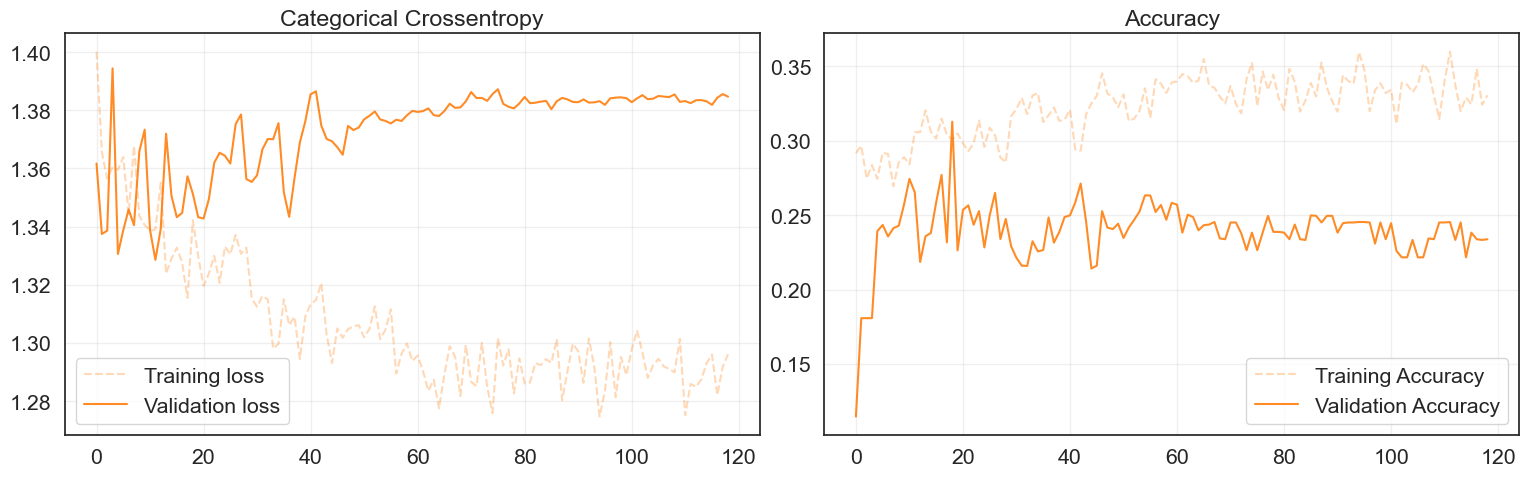

In [ ]:
# @title Plot History
# Create a figure with two side-by-side subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(scratch_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(scratch_history['val_loss'], label='Validation loss', alpha=0.9, color="#ff7e0e")
ax1.set_title('Categorical Crossentropy')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation Accuracy on the second axis
ax2.plot(scratch_history['train_acc'], label='Training Accuracy', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(scratch_history['val_acc'], label='Validation Accuracy', alpha=0.9, color='#ff7f0e')
ax2.set_title('Accuracy')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

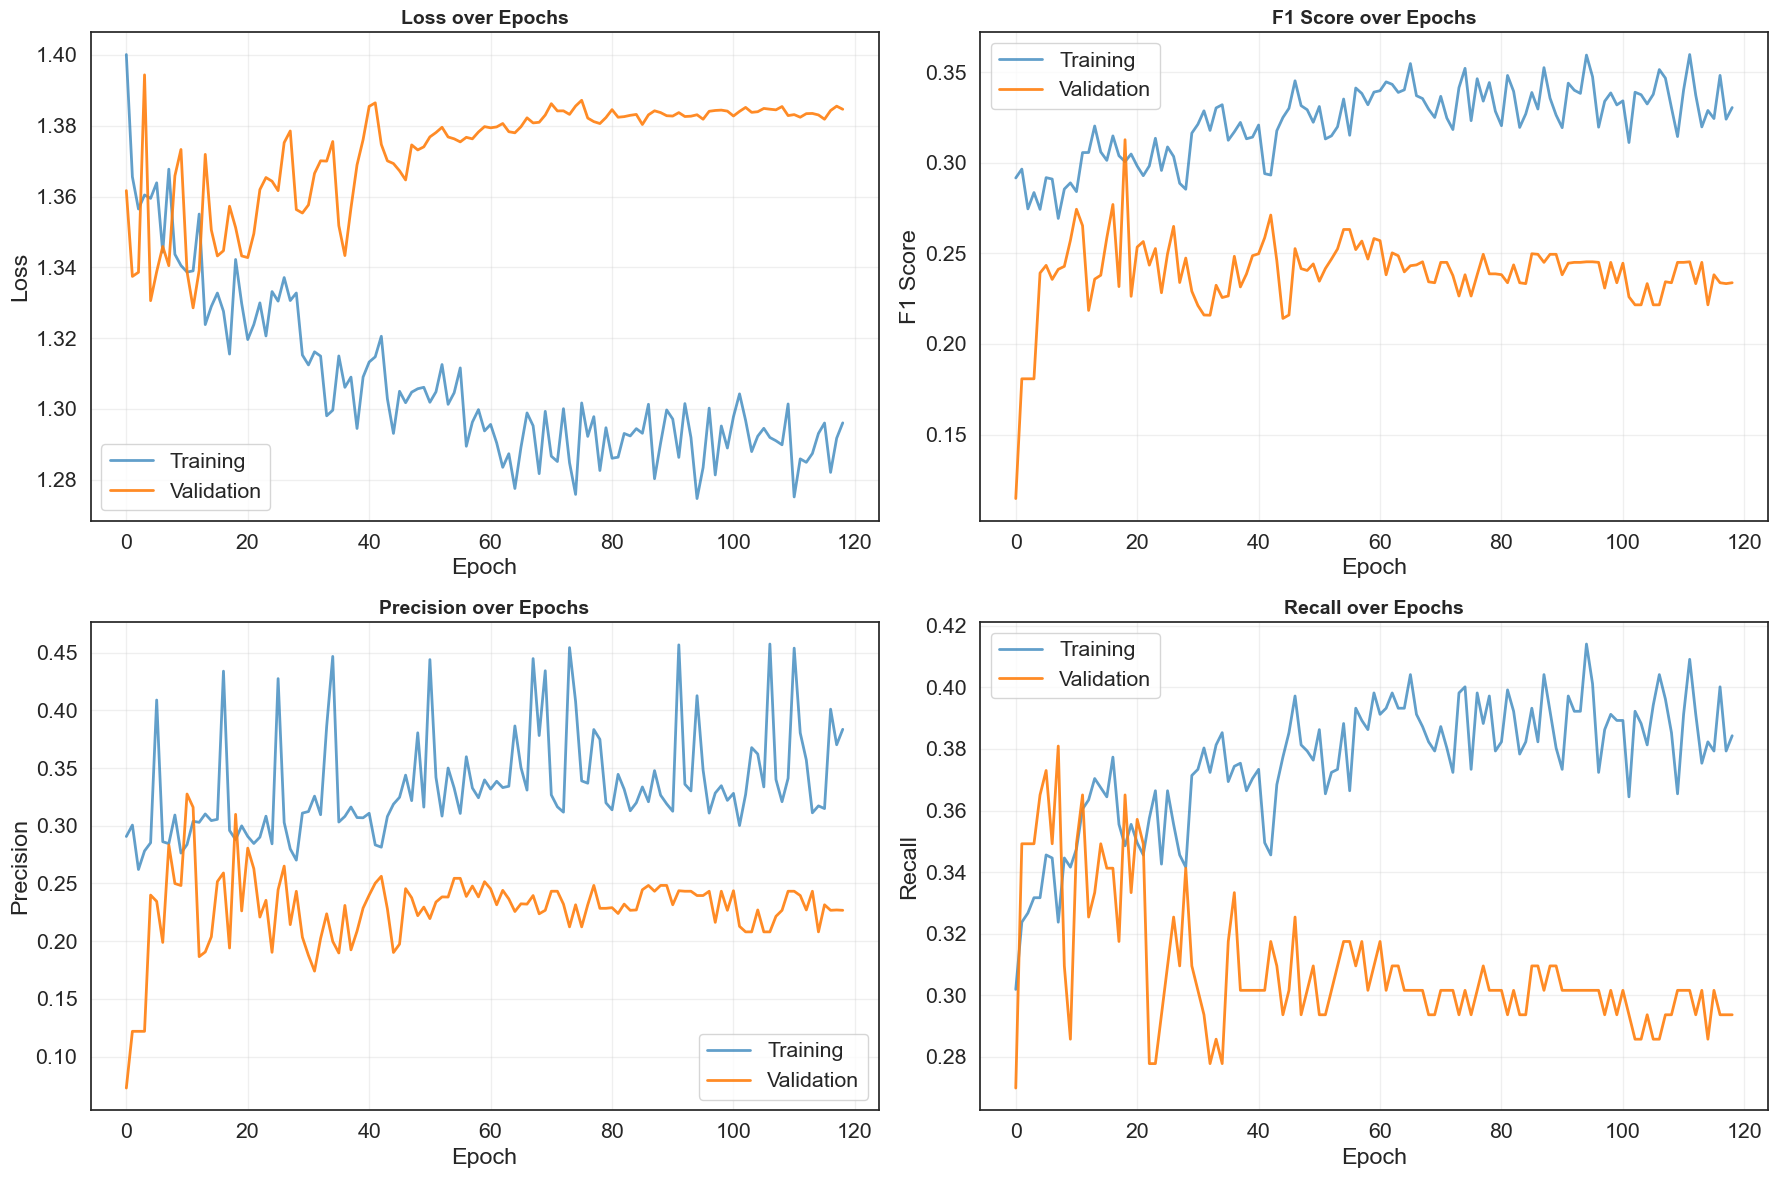


Training Summary:
Best Training   - Loss: 1.2747, F1: 0.3597, Prec: 0.4574, Rec: 0.4141
Best Validation - Loss: 1.3286, F1: 0.3127, Prec: 0.3275, Rec: 0.3810


In [ ]:
# Enhanced training history visualization with all metrics
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Loss plot
axes[0, 0].plot(scratch_history['train_loss'], label='Training', alpha=0.7, color='#1f77b4', linewidth=2)
axes[0, 0].plot(scratch_history['val_loss'], label='Validation', alpha=0.9, color='#ff7f0e', linewidth=2)
axes[0, 0].set_title('Loss over Epochs', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# F1 Score plot
axes[0, 1].plot(scratch_history['train_f1'], label='Training', alpha=0.7, color='#1f77b4', linewidth=2)
axes[0, 1].plot(scratch_history['val_f1'], label='Validation', alpha=0.9, color='#ff7f0e', linewidth=2)
axes[0, 1].set_title('F1 Score over Epochs', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('F1 Score')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Precision plot
axes[1, 0].plot(scratch_history['train_precision'], label='Training', alpha=0.7, color='#1f77b4', linewidth=2)
axes[1, 0].plot(scratch_history['val_precision'], label='Validation', alpha=0.9, color='#ff7f0e', linewidth=2)
axes[1, 0].set_title('Precision over Epochs', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Recall plot
axes[1, 1].plot(scratch_history['train_recall'], label='Training', alpha=0.7, color='#1f77b4', linewidth=2)
axes[1, 1].plot(scratch_history['val_recall'], label='Validation', alpha=0.9, color='#ff7f0e', linewidth=2)
axes[1, 1].set_title('Recall over Epochs', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("Training Summary:")
print("="*60)
print(f"Best Training   - Loss: {min(scratch_history['train_loss']):.4f}, F1: {max(scratch_history['train_f1']):.4f}, "
      f"Prec: {max(scratch_history['train_precision']):.4f}, Rec: {max(scratch_history['train_recall']):.4f}")
print(f"Best Validation - Loss: {min(scratch_history['val_loss']):.4f}, F1: {max(scratch_history['val_f1']):.4f}, "
      f"Prec: {max(scratch_history['val_precision']):.4f}, Rec: {max(scratch_history['val_recall']):.4f}")
print("="*60)

In [ ]:
# Make predictions on the test set created inside the training set
test_scratch_ds = TissueDataset(X_test, y_test, augmentation=None, normalize_imagenet=False)
test_scratch_loader = make_loader(test_scratch_ds, BATCH_SIZE, shuffle=False, drop_last=False)

best_val_acc = max(scratch_history['val_acc'])
model_path = Path(f"models/{experiment_name}_{best_val_acc:.4f}_model.pt")
if not model_path.exists():
    candidates = sorted(Path("models").glob(f"{experiment_name}_*_model.pt"))
    if candidates:
        model_path = candidates[-1]
    else:
        raise FileNotFoundError(f"No model file matching {model_path.name}")
scratch_model.load_state_dict(torch.load(model_path, map_location=device))
scratch_model.eval()
print(f"Loaded weights from {model_path.name}")

all_test_predictions = []
with torch.no_grad():
    for inputs, _ in test_scratch_loader:
        inputs = inputs.to(device)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = scratch_model(inputs)
        predictions = logits.argmax(dim=1)
        all_test_predictions.append(predictions.cpu().numpy())
all_test_predictions = np.concatenate(all_test_predictions)

# Calculate test metrics
test_f1 = f1_score(y_test, all_test_predictions, average='weighted')
test_precision = precision_score(y_test, all_test_predictions, average='weighted', zero_division=0)
test_recall = recall_score(y_test, all_test_predictions, average='weighted', zero_division=0)
print(f"\nTest Set Performance:")
print(f"F1 Score: {test_f1:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")

FileNotFoundError: No model file matching from_scratch_0.3127_model.pt

## 🛠️ **Transfer Learining**

In [893]:
class ResNetTransferLearning(nn.Module):
    """ResNet with ImageNet pretrained weights."""

    def __init__(self, num_classes, dropout_rate=0.3, freeze_backbone=True):
        super().__init__()

        # Load weights pretrained on ImageNet
        self.backbone = torchvision.models.resnet50(
            weights=torchvision.models.ResNet50_Weights.DEFAULT
        )

        # Freeze the backbone layers (features)
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False

        # Replace classifier (Always trainable)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(p=dropout_rate, inplace=True),
            nn.Linear(in_features, num_classes),
        )

    def forward(self, x):
        return self.backbone(x)

In [894]:
# Create transfer learning model
tl_model = ResNetTransferLearning(num_classes, DROPOUT_RATE, freeze_backbone=True).to(device)

# Display model summary
summary(tl_model, input_size=input_shape)
# model_graph = draw_graph(tl_model, input_size=(BATCH_SIZE,)+input_shape, expand_nested=True, depth=6)
# model_graph.visual_graph

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [895]:
train_tl_ds = TissueDataset(X_train, y_train, augmentation=train_augmentation, normalize_imagenet=True)
val_tl_ds = TissueDataset(X_val, y_val, augmentation=None, normalize_imagenet=True)

train_tl_loader = make_loader(train_tl_ds, BATCH_SIZE, shuffle=True, drop_last=False)
val_tl_loader = make_loader(val_tl_ds, BATCH_SIZE, shuffle=False, drop_last=False)

In [896]:
# Setup training for transfer learning (without mixed precision)
experiment_name = "transfer_learning"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)

# Create optimizer for transfer learning model
optimizer = torch.optim.Adam(tl_model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# Add learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5
)

print(f"Experiment: {experiment_name}")
print(f"Device: {device}")
print(f"Mixed precision: Disabled (scaler=None)")
print(f"Learning rate: {LEARNING_RATE}")

Experiment: transfer_learning
Device: cuda
Mixed precision: Disabled (scaler=None)
Learning rate: 0.0003


In [897]:
# Train with transfer learning (no mixed precision scaler)
tl_model, tl_history = fit(
    model=tl_model,
    train_loader=train_tl_loader,
    val_loader=val_tl_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=None,  # Disable mixed precision for transfer learning
    device=device,
    writer=writer,
    scheduler=scheduler,
    verbose=5,
    experiment_name=experiment_name,
    patience=PATIENCE
)

final_val_f1 = round(max(tl_history['val_f1']) * 100, 2)
final_train_f1 = round(max(tl_history['train_f1']) * 100, 2)
print(f'\n{"="*60}')
print(f'Training Complete!')
print(f'Best Training F1: {final_train_f1}%')
print(f'Best Validation F1: {final_val_f1}%')
print(f'{"="*60}')

Training 200 epochs...
Epoch   5/200 | Train: Loss=1.3231, F1=0.2174, Prec=0.2844, Rec=0.3476 | Val: Loss=1.3437, F1=0.2307, Prec=0.2517, Rec=0.3254
Epoch   5/200 | Train: Loss=1.3231, F1=0.2174, Prec=0.2844, Rec=0.3476 | Val: Loss=1.3437, F1=0.2307, Prec=0.2517, Rec=0.3254
Epoch  10/200 | Train: Loss=1.3296, F1=0.2427, Prec=0.3281, Rec=0.3635 | Val: Loss=1.3258, F1=0.1903, Prec=0.1663, Rec=0.3333
Epoch  10/200 | Train: Loss=1.3296, F1=0.2427, Prec=0.3281, Rec=0.3635 | Val: Loss=1.3258, F1=0.1903, Prec=0.1663, Rec=0.3333
Epoch  15/200 | Train: Loss=1.3202, F1=0.2397, Prec=0.2865, Rec=0.3496 | Val: Loss=1.3266, F1=0.1913, Prec=0.1673, Rec=0.3333
Epoch  15/200 | Train: Loss=1.3202, F1=0.2397, Prec=0.2865, Rec=0.3496 | Val: Loss=1.3266, F1=0.1913, Prec=0.1673, Rec=0.3333
Epoch  20/200 | Train: Loss=1.3217, F1=0.2616, Prec=0.3432, Rec=0.3694 | Val: Loss=1.3274, F1=0.1949, Prec=0.1783, Rec=0.3413
Epoch  20/200 | Train: Loss=1.3217, F1=0.2616, Prec=0.3432, Rec=0.3694 | Val: Loss=1.3274, F1=0

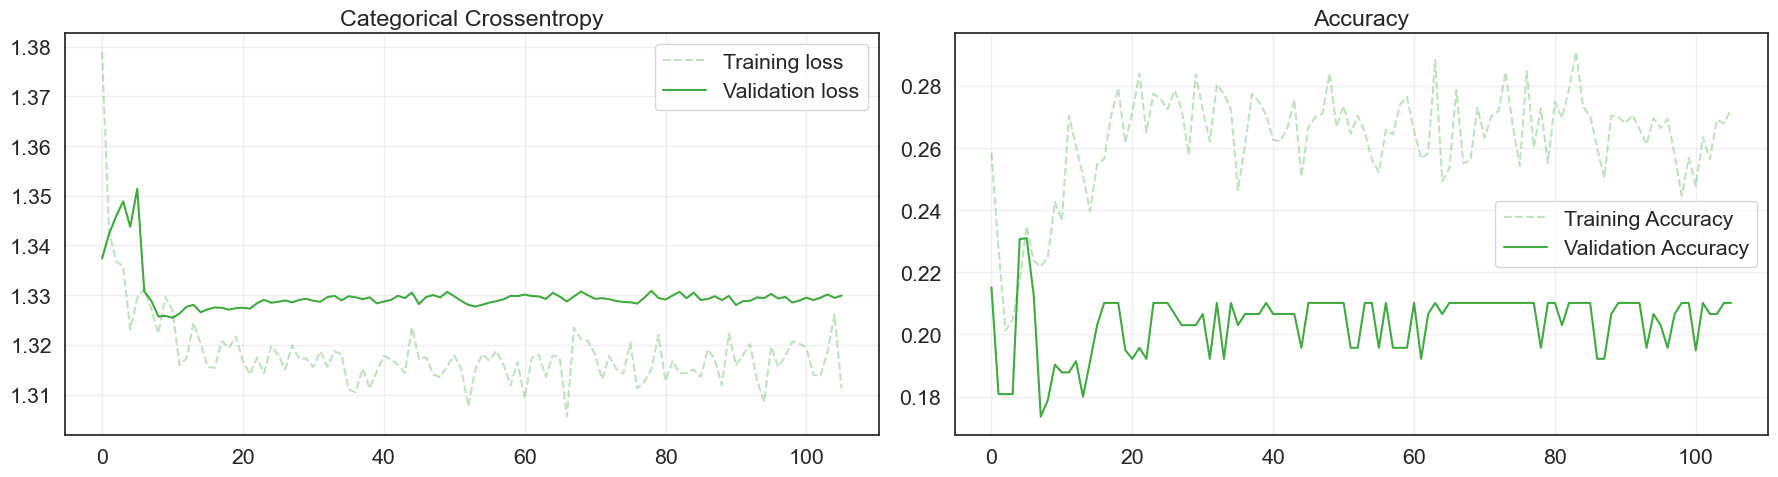

In [898]:
# Plot the results of the transfer learning training
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(tl_history['train_loss'], label='Training loss', alpha=0.3, color='#2ca02c', linestyle='--')
ax1.plot(tl_history['val_loss'], label='Validation loss', alpha=0.9, color="#2ca02c")
ax1.set_title('Categorical Crossentropy') 
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation Accuracy on the second axis
ax2.plot(tl_history['train_acc'], label='Training Accuracy', alpha=0.3, color='#2ca02c', linestyle='--')
ax2.plot(tl_history['val_acc'], label='Validation Accuracy', alpha=0.9, color='#2ca02c')
ax2.set_title('Accuracy')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

## **Submission**

In [558]:
# Process test images through the same pipeline as training images
TEST_MASKED_PATH = os.path.join(datasets_path, "test_masked")
os.makedirs(TEST_MASKED_PATH, exist_ok=True)

# Apply masking and resizing to test images
process_batch(str(test_data_path), TEST_MASKED_PATH, target_size=(224, 224))

# Load processed test images
test_images = load_images_from_folder(TEST_MASKED_PATH)

print(f"Loaded and processed {len(test_images)} test images.")
print(f"Test images shape: {test_images.shape}")

Scanning for images in: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2_prev\test_data...


Processing Images: 100%|██████████| 954/954 [00:21<00:00, 43.46img/s]


Batch processing complete. Processed 954 new images.


Loading images from test_masked: 100%|██████████| 954/954 [00:08<00:00, 113.58it/s]



Loaded and processed 954 test images.
Test images shape: (954, 224, 224, 3)


In [562]:
# Load the best model and evaluate on test set
scratch_model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
scratch_model.eval()

test_scratch_ds = TissueDataset(test_images, np.zeros(len(test_images)), augmentation=None, normalize_imagenet=False)
test_scratch_loader = make_loader(test_scratch_ds, BATCH_SIZE, shuffle=False, drop_last=False)

print("\nGenerating predictions on test set...")

# Collect all predictions
all_predictions = []

with torch.no_grad():
    for inputs, _ in tqdm(test_scratch_loader, desc="Predicting"):
        inputs = inputs.to(device)
        
        # Forward pass with mixed precision
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = scratch_model(inputs)
        
        # Get predicted classes
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())

# Concatenate all predictions
all_predictions = np.concatenate(all_predictions)

print(f"\nGenerated {len(all_predictions)} predictions")
print(f"Prediction distribution: {np.bincount(all_predictions)}")

# Decode predictions back to original labels
predicted_labels = label_encoder.inverse_transform(all_predictions)

print(f"\nSample predictions:")
for i in range(min(10, len(predicted_labels))):
    print(f"  Test image {i}: {predicted_labels[i]}")


Generating predictions on test set...


Predicting: 100%|██████████| 8/8 [00:01<00:00,  5.52it/s]


Generating predictions on test set...


Predicting: 100%|██████████| 8/8 [00:01<00:00,  5.52it/s]


Generated 954 predictions
Prediction distribution: [199 114 641]

Sample predictions:
  Test image 0: HER2(+)
  Test image 1: Luminal B
  Test image 2: HER2(+)
  Test image 3: HER2(+)
  Test image 4: Luminal B
  Test image 5: Luminal B
  Test image 6: Luminal A
  Test image 7: Luminal A
  Test image 8: Luminal B
  Test image 9: Luminal B


In [563]:
# Create submission file
# Get test image filenames
test_filenames = sorted([f for f in os.listdir(TEST_MASKED_PATH) if f.startswith('img_')])

# Create submission DataFrame
submission_df = pd.DataFrame({
    'sample_index': test_filenames,
    'label': predicted_labels
})

# Save to CSV
submission_path = os.path.join(datasets_path.parent, "submission.csv")
submission_df.to_csv(submission_path, index=False)

print(f"\n{'='*60}")
print(f"Submission file saved to: {submission_path}")
print(f"Total predictions: {len(submission_df)}")
print(f"\nLabel distribution in submission:")
print(submission_df['label'].value_counts().sort_index())
print(f"{'='*60}")

# Display first few rows
print("\nFirst 10 rows of submission:")
print(submission_df.head(10))


Submission file saved to: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\submission.csv
Total predictions: 954

Label distribution in submission:
label
HER2(+)      199
Luminal A    114
Luminal B    641
Name: count, dtype: int64

First 10 rows of submission:
   sample_index      label
0  img_0000.png    HER2(+)
1  img_0001.png  Luminal B
2  img_0002.png    HER2(+)
3  img_0003.png    HER2(+)
4  img_0004.png  Luminal B
5  img_0005.png  Luminal B
6  img_0006.png  Luminal A
7  img_0007.png  Luminal A
8  img_0008.png  Luminal B
9  img_0009.png  Luminal B


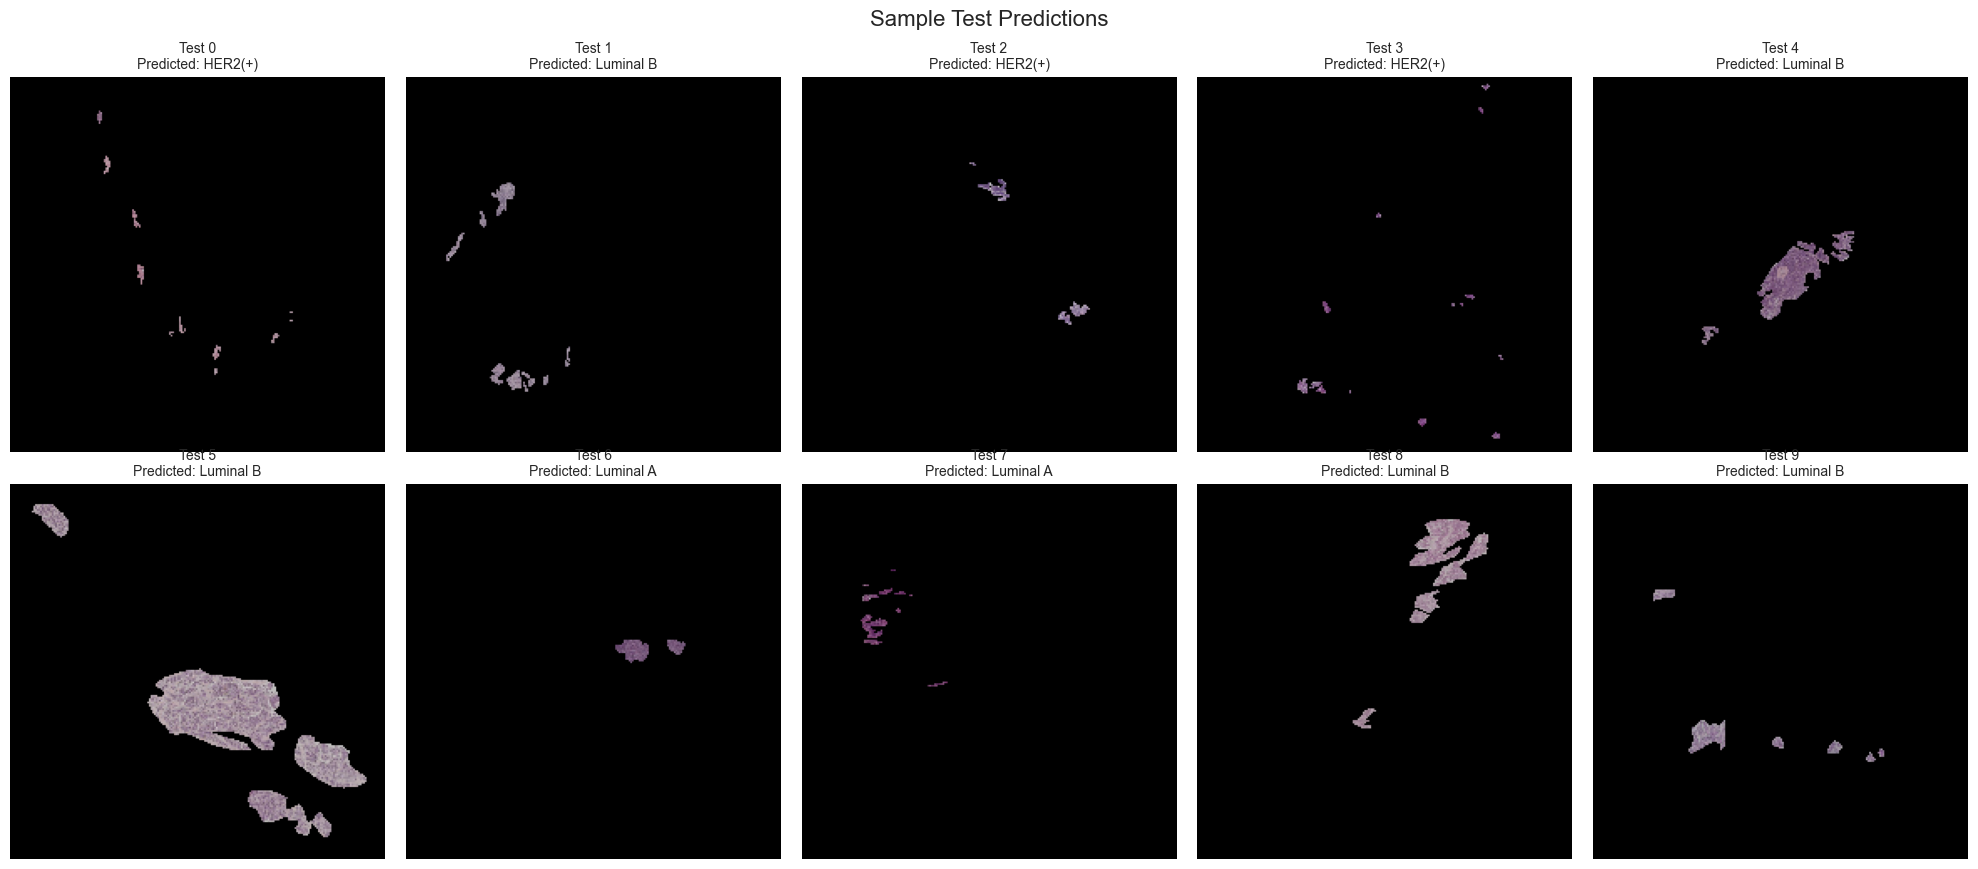

In [564]:
# Visualize some test predictions
num_display = 10
fig, axes = plt.subplots(2, 5, figsize=(20, 9))
axes = axes.flatten()

for i in range(num_display):
    axes[i].imshow(np.clip(test_images[i], 0, 1))
    axes[i].set_title(f"Test {i}\nPredicted: {predicted_labels[i]}", fontsize=10)
    axes[i].axis('off')

plt.suptitle("Sample Test Predictions", fontsize=16, y=0.98)
plt.tight_layout()
plt.show()